**Problema** : Riconoscere se il soggetto indossa una mascherina oppure non indossa nessuna protezione.

Vediamo se si modifica su git

This Image classification with Bag of Visual Words technique has three steps:
* **Feature Extraction** :Determination of Image features of a given label.
* **Codebook Construction** : Construction of visual vocabulary by clustering, followed by frequency analysis.
* **Classification** Classification of images based on vocabulary generated using SVM.


Importo le librerie che mi servono

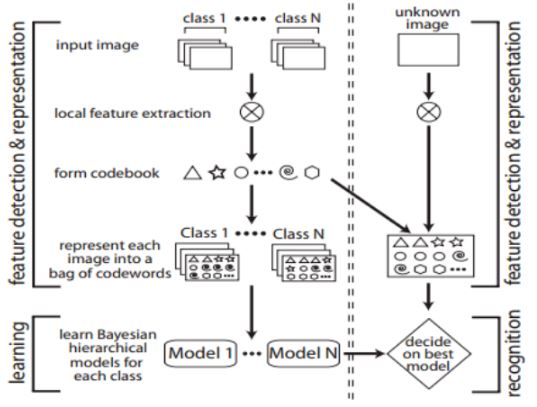

In [1]:
import numpy as np
from sklearn import svm
from sklearn.metrics import accuracy_score,confusion_matrix
import cv2 as cv
import os
import matplotlib.pyplot as plt
import random
import pylab as pl

In [2]:
train_path="archive/Face Mask Dataset/Train"
class_names=os.listdir(train_path)

In [3]:
print(class_names)

['WithMask', 'WithoutMask']


Creo due contenitori per il percoso delle immagini e la loro classe

In [4]:
image_paths=[]
image_classes=[]

Creare lista per tutti i filename nella directory

In [5]:
def img_list(path):
    return (os.path.join(path,f) for f in os.listdir(path))

In [6]:
# ciclo for su ogni classe del training set
for training_name in class_names:
    #estraggo la directory delle classi
    dir_=os.path.join(train_path,training_name)
    class_path=img_list(dir_)#class 'generator', itero sulla classe 
    image_paths+=class_path #vado a creare una lista della posizione di ogni immagine
#in totale ho 10000 immagini di test, 5000 per ogni classe

In [7]:
image_classes_0=[0]*(len(image_paths)//2)# creo label per ogni classe

In [8]:
image_classes_1=[1]*(len(image_paths)//2)# creo label per ogni classe

In [9]:
image_classes=image_classes_0+image_classes_1
len(image_classes)

10000

ora ad ogni immagine assegno l'etichetta:
* zero = withmask
* uno = withoutmask

In [10]:
D=[]
#la struttura D contiene il path dell'immagine con la sua corrispettiva etichetta
for i in range(len(image_paths)):
    D.append((image_paths[i],image_classes[i]))

Visualizzo due esempio del mio dataset di training:

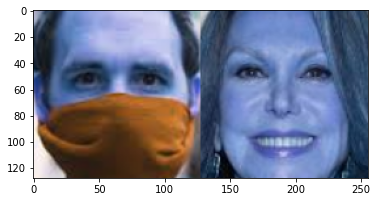

In [11]:
#visualizzo due esempi delle mie due classi 
import numpy as np
import matplotlib.pyplot as plt

img_A =  cv.imread(D[50][0])
img_B =  cv.imread(D[5000][0])

#per visualizzare le due immagini le ho inserite in un numpy array e poi ho plottato l'array
#metodo discutibile, magari da sistemare
dim=(128,128)
img_A_2= cv.resize(img_A,dim)
img_B_2= cv.resize(img_B,dim)
plot_image = np.concatenate((img_A_2, img_B_2), axis=1)

plt.imshow(plot_image)

**Estrazione delle feature con BOW** : creo feature SIFT.

<class 'cv2.xfeatures2d_SIFT'>


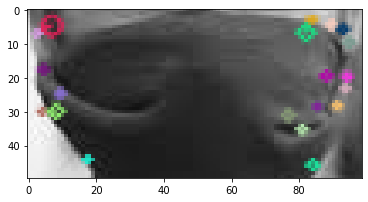

In [12]:


#calcolo che devo fare per ogni immagine e mi creo la mia lista di descrittori che sono le mie SIFT

#carico imamgine
img = cv.imread(D[50][0])
cut_image = img[img.shape[0]//2: img.shape[0], 0:img.shape[1]]


gray= cv.cvtColor(cut_image,cv.COLOR_BGR2GRAY)#la porto in scala di grigi
plt.imshow(gray)

sift = cv.xfeatures2d.SIFT_create() #creo oggetto sift
print(type(sift))

kp = sift.detect(gray,None) #trova i keypoint nell'immagine 
img_1=cv.drawKeypoints(gray,kp,cut_image,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) #disegno cerchi intorni ai miei keypoint
plt.imshow(img_1)

kp,des = sift.compute(gray,kp)#calcolo descitori, è un array di N(#keypoint)x128

In [13]:
print(des.shape) 

(21, 128)


Ora vado ad estrarmi i descrittori per ogni immagine del data_set

In [15]:
#oggetto sift già istanziato
tot_list=[]#lista descrittori con immagini associata
des_list=[] #lista per descrittori, la uso dopo

from tqdm import tqdm #algoritmo intelligente che calcola tempo di esecuzione rimanente
from time import sleep
from functools import partial
tqdm = partial(tqdm, position=0, leave=True)

for image_pat in tqdm(image_paths, desc='Calcolo Keypoint e descrittori'):
    im=cv.imread(image_pat)
    cut_image = im[im.shape[0]//2: im.shape[0], 0:im.shape[1]]
    cut_image_gray= cv.cvtColor(cut_image,cv.COLOR_BGR2GRAY)#la porto in scala di grigi
    
    kp1, descriptor = sift.detectAndCompute(cut_image_gray,None)
    tot_list.append((image_pat,descriptor))
    
    if descriptor is not None:
        des_list.extend(descriptor)

Calcolo Keypoint e descrittori: 100%|██████████| 10000/10000 [00:38<00:00, 259.16it/s]


In [ ]:
g = []
k=np.array(des_list)
print(type(k))
print(k[2])
for i in [1]:
    s=(des_list[i])
    l=np.array(s)
    g.append(l)
    print('L=', l.shape)
    print('lunghezza L= ',len(l))
    print('g=',len(g))
    #print(tot_list[i])

Implemento algorimto K-means sui descrittori, creo dizionario BOW

Il MiniBarchKmeans è una variante dell'algorimto Kmeans, il quale usa dei mini-bathes per ridurre il tempo di computazione, pur cercando di ottimizzare la stessa funzione obbiettivo.

I mini-batches sono dei subset dell'intero data set, sono randomicamente campionati in ogni iterzione di training.
Questi mini-batch riducono drasticamente la quantità di calcolo necessaria per convergere a una soluzione locale. Però k-means che utilizza dei mini-batch produce dei risultati che sono generalmente di poco peggiori dell'algoritmo standard.

**funzionamento:**
L'algoritmo itera tra due passaggi principali, in modo simile al K-means standard:
* Nel primo passo: i campioni vengono estratti casualmente dal set di dati, per formare un mini-batch. Questi vengono quindi assegnati al centroide più vicino. 
* Nella seconda fase, i centroidi vengono aggiornati. A differenza di k-means, questo viene fatto su una base per campione. Per ogni campione nel mini-batch, il centroide assegnato viene aggiornato prendendo la media in streaming del campione e tutti i campioni precedenti assegnati a quel centroide. Questo ha l'effetto di diminuire la velocità di variazione di un centroide nel tempo. Questi passaggi vengono eseguiti fino al raggiungimento della convergenza o di un numero predeterminato di iterazioni.

MiniBatchKMeans converge più velocemente di KMeans, ma la qualità dei risultati è ridotta. In pratica questa differenza di qualità può essere piuttosto piccola. [Fonte](https://scikit-learn.org/stable/auto_examples/cluster/plot_mini_batch_kmeans.html)

"Building visual dictionary using cv2.BOWKMeansTrainer is super slow when using > 100 clusters. While using sklearn.cluster.KMeans solves the speed issue, it requires huge amount of memory (8 GB of RAM is still insufficient to handle > 400 clusters). That’s where klearn.cluster.MiniBatchKMeans comes into picture." [Fonte](https://yohanes.gultom.id/2018/05/20/sift-surf-bow-for-big-number-of-clusters/)

In [16]:
from sklearn.cluster import MiniBatchKMeans

#decido quanti cluster creare e quindi quanto grande sarà il mio dizionario, attenzione a sparsità
dictionary_size=300
print('Creo dizionario BoW usando l\'algoritmo di clustering K-Means con k={}.'.format(dictionary_size))
dictionary = MiniBatchKMeans(n_clusters=dictionary_size, batch_size=100, verbose=1)
'''
n_cluster= numero di cluster che creo, ovvero il numero di centroidi che genera
batch_size= dimnsione del mio mini-batch
verbose= attivata per visualizzare maggiore informazioni
The number of clusters to form as well as the number of centroids to generate.
‘k-means++’ : selects initial cluster centers for k-mean clustering in a smart way to speed up convergence. 

'''
dictionary.fit(np.array(des_list))#calcola i centroidi dei miei descrittori suddividendoli in mini-batch


Creo dizionario BoW usando l'algoritmo di clustering K-Means con k=300.


C:\Users\tomma\anaconda3\envs\Machine_Learning\lib\site-packages\sklearn\cluster\_kmeans.py:888: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  f"MiniBatchKMeans is known to have a memory leak on "


Init 1/3 with method: k-means++
Inertia for init 1/3: 10520935.000000
Init 2/3 with method: k-means++
Inertia for init 2/3: 10343028.000000
Init 3/3 with method: k-means++
Inertia for init 3/3: 10875427.000000
Minibatch iteration 1/726600: mean batch inertia: 106876.690000, ewa inertia: 106876.690000 
Minibatch iteration 2/726600: mean batch inertia: 102223.330000, ewa inertia: 106875.409058 
Minibatch iteration 3/726600: mean batch inertia: 101306.660000, ewa inertia: 106873.876135 
Minibatch iteration 4/726600: mean batch inertia: 98730.730000, ewa inertia: 106871.634552 
Minibatch iteration 5/726600: mean batch inertia: 96953.060000, ewa inertia: 106868.904242 
Minibatch iteration 6/726600: mean batch inertia: 104694.620000, ewa inertia: 106868.305721 
Minibatch iteration 7/726600: mean batch inertia: 92848.440000, ewa inertia: 106864.446439 
Minibatch iteration 8/726600: mean batch inertia: 92275.240000, ewa inertia: 106860.430433 
Minibatch iteration 9/726600: mean batch inertia: 

Minibatch iteration 126/726600: mean batch inertia: 78451.910000, ewa inertia: 106099.071725 
Minibatch iteration 127/726600: mean batch inertia: 81305.655000, ewa inertia: 106092.246782 
Minibatch iteration 128/726600: mean batch inertia: 77006.550000, ewa inertia: 106084.240292 
Minibatch iteration 129/726600: mean batch inertia: 85493.250000, ewa inertia: 106078.572160 
Minibatch iteration 130/726600: mean batch inertia: 80022.195000, ewa inertia: 106071.399558 
Minibatch iteration 131/726600: mean batch inertia: 76848.805000, ewa inertia: 106063.355384 
Minibatch iteration 132/726600: mean batch inertia: 81839.150000, ewa inertia: 106056.687128 
Minibatch iteration 133/726600: mean batch inertia: 80188.955000, ewa inertia: 106049.566455 
Minibatch iteration 134/726600: mean batch inertia: 79671.620000, ewa inertia: 106042.305334 
Minibatch iteration 135/726600: mean batch inertia: 80290.275000, ewa inertia: 106035.216511 
Minibatch iteration 136/726600: mean batch inertia: 81616.74

Minibatch iteration 213/726600: mean batch inertia: 75987.535000, ewa inertia: 105454.777753 
Minibatch iteration 214/726600: mean batch inertia: 75944.025000, ewa inertia: 105446.654257 
Minibatch iteration 215/726600: mean batch inertia: 75684.630000, ewa inertia: 105438.461593 
Minibatch iteration 216/726600: mean batch inertia: 78086.560000, ewa inertia: 105430.932369 
Minibatch iteration 217/726600: mean batch inertia: 77991.760000, ewa inertia: 105423.379122 
Minibatch iteration 218/726600: mean batch inertia: 79841.460000, ewa inertia: 105416.337125 
Minibatch iteration 219/726600: mean batch inertia: 75977.405000, ewa inertia: 105408.233399 
Minibatch iteration 220/726600: mean batch inertia: 80945.385000, ewa inertia: 105401.499452 
Minibatch iteration 221/726600: mean batch inertia: 79506.100000, ewa inertia: 105394.371162 
Minibatch iteration 222/726600: mean batch inertia: 82836.390000, ewa inertia: 105388.161572 
Minibatch iteration 223/726600: mean batch inertia: 77220.64

Minibatch iteration 310/726600: mean batch inertia: 75066.350000, ewa inertia: 104724.187568 
Minibatch iteration 311/726600: mean batch inertia: 81284.250000, ewa inertia: 104717.735200 
Minibatch iteration 312/726600: mean batch inertia: 77221.890000, ewa inertia: 104710.166352 
Minibatch iteration 313/726600: mean batch inertia: 77231.470000, ewa inertia: 104702.602225 
Minibatch iteration 314/726600: mean batch inertia: 77281.570000, ewa inertia: 104695.053971 
Minibatch iteration 315/726600: mean batch inertia: 78200.390000, ewa inertia: 104687.760721 
Minibatch iteration 316/726600: mean batch inertia: 78192.405000, ewa inertia: 104680.467280 
Minibatch iteration 317/726600: mean batch inertia: 81691.060000, ewa inertia: 104674.138931 
Minibatch iteration 318/726600: mean batch inertia: 75162.595000, ewa inertia: 104666.015217 
Minibatch iteration 319/726600: mean batch inertia: 79308.340000, ewa inertia: 104659.034948 
Minibatch iteration 320/726600: mean batch inertia: 77400.94

Minibatch iteration 404/726600: mean batch inertia: 79509.120000, ewa inertia: 104021.371777 
Minibatch iteration 405/726600: mean batch inertia: 77316.945000, ewa inertia: 104014.020785 
Minibatch iteration 406/726600: mean batch inertia: 80522.060000, ewa inertia: 104007.554096 
Minibatch iteration 407/726600: mean batch inertia: 78823.440000, ewa inertia: 104000.621604 
Minibatch iteration 408/726600: mean batch inertia: 74139.410000, ewa inertia: 103992.401637 
Minibatch iteration 409/726600: mean batch inertia: 74921.955000, ewa inertia: 103984.399344 
Minibatch iteration 410/726600: mean batch inertia: 73463.530000, ewa inertia: 103975.997791 
Minibatch iteration 411/726600: mean batch inertia: 79298.425000, ewa inertia: 103969.204736 
Minibatch iteration 412/726600: mean batch inertia: 73322.740000, ewa inertia: 103960.768609 
Minibatch iteration 413/726600: mean batch inertia: 79602.525000, ewa inertia: 103954.063457 
Minibatch iteration 414/726600: mean batch inertia: 75320.08

Minibatch iteration 506/726600: mean batch inertia: 73910.570000, ewa inertia: 103264.136382 
Minibatch iteration 507/726600: mean batch inertia: 77333.505000, ewa inertia: 103256.998394 
Minibatch iteration 508/726600: mean batch inertia: 77434.485000, ewa inertia: 103249.890168 
Minibatch iteration 509/726600: mean batch inertia: 76792.075000, ewa inertia: 103242.607062 
Minibatch iteration 510/726600: mean batch inertia: 75760.485000, ewa inertia: 103235.041991 
Minibatch iteration 511/726600: mean batch inertia: 78382.335000, ewa inertia: 103228.200727 
Minibatch iteration 512/726600: mean batch inertia: 74877.180000, ewa inertia: 103220.396473 
Minibatch iteration 513/726600: mean batch inertia: 75051.225000, ewa inertia: 103212.642277 
Minibatch iteration 514/726600: mean batch inertia: 77695.335000, ewa inertia: 103205.618066 
Minibatch iteration 515/726600: mean batch inertia: 77807.620000, ewa inertia: 103198.626698 
Minibatch iteration 516/726600: mean batch inertia: 73901.38

Minibatch iteration 642/726600: mean batch inertia: 77159.680000, ewa inertia: 102265.173266 
Minibatch iteration 643/726600: mean batch inertia: 79399.435000, ewa inertia: 102258.878959 
Minibatch iteration 644/726600: mean batch inertia: 77143.585000, ewa inertia: 102251.965411 
Minibatch iteration 645/726600: mean batch inertia: 78186.715000, ewa inertia: 102245.340911 
Minibatch iteration 646/726600: mean batch inertia: 74572.150000, ewa inertia: 102237.723245 
Minibatch iteration 647/726600: mean batch inertia: 74710.080000, ewa inertia: 102230.145644 
Minibatch iteration 648/726600: mean batch inertia: 79093.645000, ewa inertia: 102223.776804 
Minibatch iteration 649/726600: mean batch inertia: 74219.165000, ewa inertia: 102216.067907 
Minibatch iteration 650/726600: mean batch inertia: 75207.980000, ewa inertia: 102208.633325 
Minibatch iteration 651/726600: mean batch inertia: 73000.145000, ewa inertia: 102200.593034 
Minibatch iteration 652/726600: mean batch inertia: 81669.65

Minibatch iteration 730/726600: mean batch inertia: 77272.360000, ewa inertia: 101633.087902 
Minibatch iteration 731/726600: mean batch inertia: 79130.285000, ewa inertia: 101626.893501 
Minibatch iteration 732/726600: mean batch inertia: 80070.615000, ewa inertia: 101620.959653 
Minibatch iteration 733/726600: mean batch inertia: 80936.425000, ewa inertia: 101615.265771 
Minibatch iteration 734/726600: mean batch inertia: 74833.125000, ewa inertia: 101607.893386 
Minibatch iteration 735/726600: mean batch inertia: 76358.470000, ewa inertia: 101600.942916 
Minibatch iteration 736/726600: mean batch inertia: 78207.700000, ewa inertia: 101594.503402 
Minibatch iteration 737/726600: mean batch inertia: 73961.540000, ewa inertia: 101586.896809 
Minibatch iteration 738/726600: mean batch inertia: 76426.475000, ewa inertia: 101579.970839 
Minibatch iteration 739/726600: mean batch inertia: 75328.125000, ewa inertia: 101572.744430 
Minibatch iteration 740/726600: mean batch inertia: 75369.60

Minibatch iteration 821/726600: mean batch inertia: 74376.365000, ewa inertia: 100998.969346 
Minibatch iteration 822/726600: mean batch inertia: 72987.355000, ewa inertia: 100991.258522 
Minibatch iteration 823/726600: mean batch inertia: 70926.285000, ewa inertia: 100982.982464 
Minibatch iteration 824/726600: mean batch inertia: 74345.720000, ewa inertia: 100975.649960 
Minibatch iteration 825/726600: mean batch inertia: 76128.180000, ewa inertia: 100968.810137 
Minibatch iteration 826/726600: mean batch inertia: 72894.675000, ewa inertia: 100961.082102 
Minibatch iteration 827/726600: mean batch inertia: 79074.005000, ewa inertia: 100955.057193 
Minibatch iteration 828/726600: mean batch inertia: 74408.755000, ewa inertia: 100947.749729 
Minibatch iteration 829/726600: mean batch inertia: 74552.130000, ewa inertia: 100940.483743 
Minibatch iteration 830/726600: mean batch inertia: 76595.120000, ewa inertia: 100933.782135 
Minibatch iteration 831/726600: mean batch inertia: 73911.61

Minibatch iteration 919/726600: mean batch inertia: 74809.905000, ewa inertia: 100323.615235 
Minibatch iteration 920/726600: mean batch inertia: 78142.460000, ewa inertia: 100317.509374 
Minibatch iteration 921/726600: mean batch inertia: 77988.410000, ewa inertia: 100311.362789 
Minibatch iteration 922/726600: mean batch inertia: 74804.170000, ewa inertia: 100304.341363 
Minibatch iteration 923/726600: mean batch inertia: 78860.555000, ewa inertia: 100298.438480 
Minibatch iteration 924/726600: mean batch inertia: 78188.610000, ewa inertia: 100292.352254 
Minibatch iteration 925/726600: mean batch inertia: 76007.240000, ewa inertia: 100285.667232 
Minibatch iteration 926/726600: mean batch inertia: 77616.830000, ewa inertia: 100279.427127 
Minibatch iteration 927/726600: mean batch inertia: 75497.495000, ewa inertia: 100272.605344 
Minibatch iteration 928/726600: mean batch inertia: 78658.295000, ewa inertia: 100266.655521 
Minibatch iteration 929/726600: mean batch inertia: 74091.84

Minibatch iteration 1014/726600: mean batch inertia: 74891.580000, ewa inertia: 99705.773850 
Minibatch iteration 1015/726600: mean batch inertia: 78990.525000, ewa inertia: 99700.071514 
Minibatch iteration 1016/726600: mean batch inertia: 76836.630000, ewa inertia: 99693.777839 
Minibatch iteration 1017/726600: mean batch inertia: 71525.575000, ewa inertia: 99686.023910 
Minibatch iteration 1018/726600: mean batch inertia: 75868.805000, ewa inertia: 99679.467686 
Minibatch iteration 1019/726600: mean batch inertia: 70950.255000, ewa inertia: 99671.559327 
Minibatch iteration 1020/726600: mean batch inertia: 76774.135000, ewa inertia: 99665.256297 
Minibatch iteration 1021/726600: mean batch inertia: 75875.535000, ewa inertia: 99658.707643 
Minibatch iteration 1022/726600: mean batch inertia: 75381.770000, ewa inertia: 99652.024872 
Minibatch iteration 1023/726600: mean batch inertia: 77938.480000, ewa inertia: 99646.047732 
Minibatch iteration 1024/726600: mean batch inertia: 74112.8

Minibatch iteration 1115/726600: mean batch inertia: 72822.945000, ewa inertia: 99043.624616 
Minibatch iteration 1116/726600: mean batch inertia: 76297.370000, ewa inertia: 99037.363199 
Minibatch iteration 1117/726600: mean batch inertia: 78276.850000, ewa inertia: 99031.648403 
Minibatch iteration 1118/726600: mean batch inertia: 73118.105000, ewa inertia: 99024.515119 
Minibatch iteration 1119/726600: mean batch inertia: 75952.485000, ewa inertia: 99018.164026 
Minibatch iteration 1120/726600: mean batch inertia: 70461.900000, ewa inertia: 99010.303274 
Minibatch iteration 1121/726600: mean batch inertia: 73112.280000, ewa inertia: 99003.174262 
Minibatch iteration 1122/726600: mean batch inertia: 76008.980000, ewa inertia: 98996.844595 
Minibatch iteration 1123/726600: mean batch inertia: 78878.800000, ewa inertia: 98991.306652 
Minibatch iteration 1124/726600: mean batch inertia: 80659.380000, ewa inertia: 98986.260378 
Minibatch iteration 1125/726600: mean batch inertia: 71271.6

Minibatch iteration 1214/726600: mean batch inertia: 74045.870000, ewa inertia: 98406.088442 
Minibatch iteration 1215/726600: mean batch inertia: 69522.050000, ewa inertia: 98398.137463 
Minibatch iteration 1216/726600: mean batch inertia: 74527.505000, ewa inertia: 98391.566536 
Minibatch iteration 1217/726600: mean batch inertia: 77124.390000, ewa inertia: 98385.712269 
Minibatch iteration 1218/726600: mean batch inertia: 75117.920000, ewa inertia: 98379.307288 
Minibatch iteration 1219/726600: mean batch inertia: 77599.395000, ewa inertia: 98373.587151 
Minibatch iteration 1220/726600: mean batch inertia: 75902.305000, ewa inertia: 98367.401427 
Minibatch iteration 1221/726600: mean batch inertia: 74629.410000, ewa inertia: 98360.867013 
Minibatch iteration 1222/726600: mean batch inertia: 78014.445000, ewa inertia: 98355.266204 
Minibatch iteration 1223/726600: mean batch inertia: 72943.520000, ewa inertia: 98348.271051 
Minibatch iteration 1224/726600: mean batch inertia: 74769.4

Minibatch iteration 1308/726600: mean batch inertia: 74206.770000, ewa inertia: 97815.409095 
Minibatch iteration 1309/726600: mean batch inertia: 74063.895000, ewa inertia: 97808.870959 
Minibatch iteration 1310/726600: mean batch inertia: 79986.675000, ewa inertia: 97803.965000 
Minibatch iteration 1311/726600: mean batch inertia: 77699.550000, ewa inertia: 97798.430809 
Minibatch iteration 1312/726600: mean batch inertia: 80366.970000, ewa inertia: 97793.632408 
Minibatch iteration 1313/726600: mean batch inertia: 78096.310000, ewa inertia: 97788.210279 
Minibatch iteration 1314/726600: mean batch inertia: 76419.825000, ewa inertia: 97782.328152 
Minibatch iteration 1315/726600: mean batch inertia: 77382.395000, ewa inertia: 97776.712613 
Minibatch iteration 1316/726600: mean batch inertia: 76244.820000, ewa inertia: 97770.785477 
Minibatch iteration 1317/726600: mean batch inertia: 74121.495000, ewa inertia: 97764.275479 
Minibatch iteration 1318/726600: mean batch inertia: 78337.5

Minibatch iteration 1403/726600: mean batch inertia: 75566.360000, ewa inertia: 97243.359161 
Minibatch iteration 1404/726600: mean batch inertia: 78638.395000, ewa inertia: 97238.237728 
Minibatch iteration 1405/726600: mean batch inertia: 72831.630000, ewa inertia: 97231.519262 
Minibatch iteration 1406/726600: mean batch inertia: 76137.610000, ewa inertia: 97225.712691 
Minibatch iteration 1407/726600: mean batch inertia: 76178.405000, ewa inertia: 97219.918947 
Minibatch iteration 1408/726600: mean batch inertia: 79219.965000, ewa inertia: 97214.964057 
Minibatch iteration 1409/726600: mean batch inertia: 73372.715000, ewa inertia: 97208.400943 
Minibatch iteration 1410/726600: mean batch inertia: 81605.700000, ewa inertia: 97204.105950 
Minibatch iteration 1411/726600: mean batch inertia: 70628.915000, ewa inertia: 97196.790533 
Minibatch iteration 1412/726600: mean batch inertia: 76740.290000, ewa inertia: 97191.159423 
Minibatch iteration 1413/726600: mean batch inertia: 74748.4

Minibatch iteration 1502/726600: mean batch inertia: 74550.630000, ewa inertia: 96662.450727 
Minibatch iteration 1503/726600: mean batch inertia: 73203.150000, ewa inertia: 96655.993029 
Minibatch iteration 1504/726600: mean batch inertia: 74681.305000, ewa inertia: 96649.944003 
Minibatch iteration 1505/726600: mean batch inertia: 71942.540000, ewa inertia: 96643.142736 
Minibatch iteration 1506/726600: mean batch inertia: 76603.680000, ewa inertia: 96637.626425 
Minibatch iteration 1507/726600: mean batch inertia: 73000.055000, ewa inertia: 96631.119654 
Minibatch iteration 1508/726600: mean batch inertia: 78114.145000, ewa inertia: 96626.022441 
Minibatch iteration 1509/726600: mean batch inertia: 73314.535000, ewa inertia: 96619.605432 
Minibatch iteration 1510/726600: mean batch inertia: 77221.170000, ewa inertia: 96614.265578 
Minibatch iteration 1511/726600: mean batch inertia: 79931.495000, ewa inertia: 96609.673271 
Minibatch iteration 1512/726600: mean batch inertia: 75310.1

Minibatch iteration 1600/726600: mean batch inertia: 75174.970000, ewa inertia: 96097.798617 
Minibatch iteration 1601/726600: mean batch inertia: 75061.885000, ewa inertia: 96092.008010 
Minibatch iteration 1602/726600: mean batch inertia: 74863.025000, ewa inertia: 96086.164256 
Minibatch iteration 1603/726600: mean batch inertia: 72057.290000, ewa inertia: 96079.549770 
Minibatch iteration 1604/726600: mean batch inertia: 78778.000000, ewa inertia: 96074.787131 
Minibatch iteration 1605/726600: mean batch inertia: 78026.070000, ewa inertia: 96069.818817 
Minibatch iteration 1606/726600: mean batch inertia: 78418.495000, ewa inertia: 96064.959894 
Minibatch iteration 1607/726600: mean batch inertia: 76890.135000, ewa inertia: 96059.681594 
Minibatch iteration 1608/726600: mean batch inertia: 72077.685000, ewa inertia: 96053.080012 
Minibatch iteration 1609/726600: mean batch inertia: 78161.370000, ewa inertia: 96048.154917 
Minibatch iteration 1610/726600: mean batch inertia: 78431.4

Minibatch iteration 1699/726600: mean batch inertia: 73128.820000, ewa inertia: 95546.931972 
Minibatch iteration 1700/726600: mean batch inertia: 74256.640000, ewa inertia: 95541.071341 
Minibatch iteration 1701/726600: mean batch inertia: 72524.810000, ewa inertia: 95534.735600 
Minibatch iteration 1702/726600: mean batch inertia: 73567.695000, ewa inertia: 95528.688679 
Minibatch iteration 1703/726600: mean batch inertia: 74573.660000, ewa inertia: 95522.920338 
Minibatch iteration 1704/726600: mean batch inertia: 76812.365000, ewa inertia: 95517.769838 
Minibatch iteration 1705/726600: mean batch inertia: 72585.945000, ewa inertia: 95511.457339 
Minibatch iteration 1706/726600: mean batch inertia: 74220.925000, ewa inertia: 95505.596643 
Minibatch iteration 1707/726600: mean batch inertia: 74630.660000, ewa inertia: 95499.850349 
Minibatch iteration 1708/726600: mean batch inertia: 73067.645000, ewa inertia: 95493.675381 
Minibatch iteration 1709/726600: mean batch inertia: 69835.9

Minibatch iteration 1798/726600: mean batch inertia: 76715.275000, ewa inertia: 94992.586908 
Minibatch iteration 1799/726600: mean batch inertia: 71384.050000, ewa inertia: 94986.088129 
Minibatch iteration 1800/726600: mean batch inertia: 77631.695000, ewa inertia: 94981.310944 
Minibatch iteration 1801/726600: mean batch inertia: 80598.105000, ewa inertia: 94977.351644 
Minibatch iteration 1802/726600: mean batch inertia: 76702.790000, ewa inertia: 94972.321161 
Minibatch iteration 1803/726600: mean batch inertia: 71912.325000, ewa inertia: 94965.973380 
Minibatch iteration 1804/726600: mean batch inertia: 78211.180000, ewa inertia: 94961.361248 
Minibatch iteration 1805/726600: mean batch inertia: 76615.785000, ewa inertia: 94956.311217 
Minibatch iteration 1806/726600: mean batch inertia: 77001.880000, ewa inertia: 94951.368857 
Minibatch iteration 1807/726600: mean batch inertia: 75030.210000, ewa inertia: 94945.885111 
Minibatch iteration 1808/726600: mean batch inertia: 76340.1

Minibatch iteration 1896/726600: mean batch inertia: 75177.090000, ewa inertia: 94468.042657 
Minibatch iteration 1897/726600: mean batch inertia: 73401.700000, ewa inertia: 94462.243674 
Minibatch iteration 1898/726600: mean batch inertia: 76679.475000, ewa inertia: 94457.348568 
Minibatch iteration 1899/726600: mean batch inertia: 74681.245000, ewa inertia: 94451.904753 
Minibatch iteration 1900/726600: mean batch inertia: 72015.960000, ewa inertia: 94445.728756 
Minibatch iteration 1901/726600: mean batch inertia: 75337.100000, ewa inertia: 94440.468678 
Minibatch iteration 1902/726600: mean batch inertia: 80998.180000, ewa inertia: 94436.768386 
Minibatch iteration 1903/726600: mean batch inertia: 78594.375000, ewa inertia: 94432.407412 
Minibatch iteration 1904/726600: mean batch inertia: 72339.015000, ewa inertia: 94426.325711 
Minibatch iteration 1905/726600: mean batch inertia: 71098.000000, ewa inertia: 94419.904066 
Minibatch iteration 1906/726600: mean batch inertia: 74834.8

Minibatch iteration 1996/726600: mean batch inertia: 72940.785000, ewa inertia: 93941.517958 
Minibatch iteration 1997/726600: mean batch inertia: 76010.670000, ewa inertia: 93936.582091 
Minibatch iteration 1998/726600: mean batch inertia: 75607.730000, ewa inertia: 93931.536663 
Minibatch iteration 1999/726600: mean batch inertia: 76911.140000, ewa inertia: 93926.851417 
Minibatch iteration 2000/726600: mean batch inertia: 75818.195000, ewa inertia: 93921.866604 
Minibatch iteration 2001/726600: mean batch inertia: 75674.730000, ewa inertia: 93916.843670 
Minibatch iteration 2002/726600: mean batch inertia: 77563.315000, ewa inertia: 93912.341995 
Minibatch iteration 2003/726600: mean batch inertia: 70917.295000, ewa inertia: 93906.012093 
Minibatch iteration 2004/726600: mean batch inertia: 74753.150000, ewa inertia: 93900.739838 
Minibatch iteration 2005/726600: mean batch inertia: 75787.080000, ewa inertia: 93895.753647 
Minibatch iteration 2006/726600: mean batch inertia: 74777.2

Minibatch iteration 2093/726600: mean batch inertia: 75844.410000, ewa inertia: 93447.520077 
Minibatch iteration 2094/726600: mean batch inertia: 78735.770000, ewa inertia: 93443.470338 
Minibatch iteration 2095/726600: mean batch inertia: 72240.750000, ewa inertia: 93437.633814 
Minibatch iteration 2096/726600: mean batch inertia: 78040.365000, ewa inertia: 93433.395371 
Minibatch iteration 2097/726600: mean batch inertia: 69517.075000, ewa inertia: 93426.811867 
Minibatch iteration 2098/726600: mean batch inertia: 75639.240000, ewa inertia: 93421.915440 
Minibatch iteration 2099/726600: mean batch inertia: 71597.390000, ewa inertia: 93415.907750 
Minibatch iteration 2100/726600: mean batch inertia: 72912.250000, ewa inertia: 93410.263658 
Minibatch iteration 2101/726600: mean batch inertia: 72804.925000, ewa inertia: 93404.591577 
Minibatch iteration 2102/726600: mean batch inertia: 75549.415000, ewa inertia: 93399.676539 
Minibatch iteration 2103/726600: mean batch inertia: 75255.1

Minibatch iteration 2191/726600: mean batch inertia: 71589.510000, ewa inertia: 92956.594584 
Minibatch iteration 2192/726600: mean batch inertia: 75942.600000, ewa inertia: 92951.911100 
Minibatch iteration 2193/726600: mean batch inertia: 78722.310000, ewa inertia: 92947.994084 
Minibatch iteration 2194/726600: mean batch inertia: 73381.875000, ewa inertia: 92942.608071 
Minibatch iteration 2195/726600: mean batch inertia: 73567.500000, ewa inertia: 92937.274638 
Minibatch iteration 2196/726600: mean batch inertia: 81115.740000, ewa inertia: 92934.020496 
Minibatch iteration 2197/726600: mean batch inertia: 73318.235000, ewa inertia: 92928.620811 
Minibatch iteration 2198/726600: mean batch inertia: 76454.870000, ewa inertia: 92924.086042 
Minibatch iteration 2199/726600: mean batch inertia: 74040.995000, ewa inertia: 92918.888048 
Minibatch iteration 2200/726600: mean batch inertia: 78023.015000, ewa inertia: 92914.787625 
Minibatch iteration 2201/726600: mean batch inertia: 76311.8

Minibatch iteration 2327/726600: mean batch inertia: 77089.080000, ewa inertia: 92305.425323 
Minibatch iteration 2328/726600: mean batch inertia: 77144.410000, ewa inertia: 92301.251914 
Minibatch iteration 2329/726600: mean batch inertia: 74694.720000, ewa inertia: 92296.405321 
Minibatch iteration 2330/726600: mean batch inertia: 76795.410000, ewa inertia: 92292.138325 
Minibatch iteration 2331/726600: mean batch inertia: 76176.000000, ewa inertia: 92287.701996 
Minibatch iteration 2332/726600: mean batch inertia: 74059.750000, ewa inertia: 92282.684344 
Minibatch iteration 2333/726600: mean batch inertia: 73334.525000, ewa inertia: 92277.468438 
Minibatch iteration 2334/726600: mean batch inertia: 69744.800000, ewa inertia: 92271.265816 
Minibatch iteration 2335/726600: mean batch inertia: 75909.660000, ewa inertia: 92266.761918 
Minibatch iteration 2336/726600: mean batch inertia: 76300.440000, ewa inertia: 92262.366830 
Minibatch iteration 2337/726600: mean batch inertia: 72756.4

Minibatch iteration 2422/726600: mean batch inertia: 74244.980000, ewa inertia: 91868.456964 
Minibatch iteration 2423/726600: mean batch inertia: 78627.660000, ewa inertia: 91864.812138 
Minibatch iteration 2424/726600: mean batch inertia: 77400.975000, ewa inertia: 91860.830642 
Minibatch iteration 2425/726600: mean batch inertia: 70828.120000, ewa inertia: 91855.040917 
Minibatch iteration 2426/726600: mean batch inertia: 77568.655000, ewa inertia: 91851.108269 
Minibatch iteration 2427/726600: mean batch inertia: 71011.910000, ewa inertia: 91845.371813 
Minibatch iteration 2428/726600: mean batch inertia: 73274.925000, ewa inertia: 91840.259881 
Minibatch iteration 2429/726600: mean batch inertia: 78185.880000, ewa inertia: 91836.501207 
Minibatch iteration 2430/726600: mean batch inertia: 73499.505000, ewa inertia: 91831.453537 
Minibatch iteration 2431/726600: mean batch inertia: 76875.750000, ewa inertia: 91827.336645 
Minibatch iteration 2432/726600: mean batch inertia: 74283.3

Minibatch iteration 2517/726600: mean batch inertia: 78231.705000, ewa inertia: 91435.675866 
Minibatch iteration 2518/726600: mean batch inertia: 78194.220000, ewa inertia: 91432.030858 
Minibatch iteration 2519/726600: mean batch inertia: 74491.215000, ewa inertia: 91427.367519 
Minibatch iteration 2520/726600: mean batch inertia: 78361.010000, ewa inertia: 91423.770711 
Minibatch iteration 2521/726600: mean batch inertia: 76343.905000, ewa inertia: 91419.619640 
Minibatch iteration 2522/726600: mean batch inertia: 74090.375000, ewa inertia: 91414.849377 
Minibatch iteration 2523/726600: mean batch inertia: 73798.760000, ewa inertia: 91410.000153 
Minibatch iteration 2524/726600: mean batch inertia: 74397.980000, ewa inertia: 91405.317214 
Minibatch iteration 2525/726600: mean batch inertia: 75946.480000, ewa inertia: 91401.061822 
Minibatch iteration 2526/726600: mean batch inertia: 74472.065000, ewa inertia: 91396.401736 
Minibatch iteration 2527/726600: mean batch inertia: 70959.1

Minibatch iteration 2614/726600: mean batch inertia: 77881.855000, ewa inertia: 90997.835535 
Minibatch iteration 2615/726600: mean batch inertia: 78220.315000, ewa inertia: 90994.318236 
Minibatch iteration 2616/726600: mean batch inertia: 69690.305000, ewa inertia: 90988.453828 
Minibatch iteration 2617/726600: mean batch inertia: 75337.635000, ewa inertia: 90984.145590 
Minibatch iteration 2618/726600: mean batch inertia: 73996.255000, ewa inertia: 90979.469292 
Minibatch iteration 2619/726600: mean batch inertia: 74576.435000, ewa inertia: 90974.953989 
Minibatch iteration 2620/726600: mean batch inertia: 76156.500000, ewa inertia: 90970.874877 
Minibatch iteration 2621/726600: mean batch inertia: 72154.005000, ewa inertia: 90965.695112 
Minibatch iteration 2622/726600: mean batch inertia: 75501.845000, ewa inertia: 90961.438341 
Minibatch iteration 2623/726600: mean batch inertia: 74948.070000, ewa inertia: 90957.030302 
Minibatch iteration 2624/726600: mean batch inertia: 75766.1

Minibatch iteration 2705/726600: mean batch inertia: 80896.020000, ewa inertia: 90607.433245 
Minibatch iteration 2706/726600: mean batch inertia: 74698.640000, ewa inertia: 90603.053993 
Minibatch iteration 2707/726600: mean batch inertia: 74143.325000, ewa inertia: 90598.523084 
Minibatch iteration 2708/726600: mean batch inertia: 73120.985000, ewa inertia: 90593.712000 
Minibatch iteration 2709/726600: mean batch inertia: 72540.080000, ewa inertia: 90588.742333 
Minibatch iteration 2710/726600: mean batch inertia: 75434.875000, ewa inertia: 90584.570891 
Minibatch iteration 2711/726600: mean batch inertia: 72328.645000, ewa inertia: 90579.545538 
Minibatch iteration 2712/726600: mean batch inertia: 70890.230000, ewa inertia: 90574.125613 
Minibatch iteration 2713/726600: mean batch inertia: 79217.420000, ewa inertia: 90570.999425 
Minibatch iteration 2714/726600: mean batch inertia: 73383.190000, ewa inertia: 90566.268095 
Minibatch iteration 2715/726600: mean batch inertia: 75889.1

Minibatch iteration 2800/726600: mean batch inertia: 76015.375000, ewa inertia: 90196.832304 
Minibatch iteration 2801/726600: mean batch inertia: 83544.840000, ewa inertia: 90195.001194 
Minibatch iteration 2802/726600: mean batch inertia: 77597.825000, ewa inertia: 90191.533539 
Minibatch iteration 2803/726600: mean batch inertia: 76928.255000, ewa inertia: 90187.882524 
Minibatch iteration 2804/726600: mean batch inertia: 74645.515000, ewa inertia: 90183.604139 
Minibatch iteration 2805/726600: mean batch inertia: 78328.060000, ewa inertia: 90180.340634 
Minibatch iteration 2806/726600: mean batch inertia: 75134.285000, ewa inertia: 90176.198870 
Minibatch iteration 2807/726600: mean batch inertia: 74019.305000, ewa inertia: 90171.751323 
Minibatch iteration 2808/726600: mean batch inertia: 74374.600000, ewa inertia: 90167.402803 
Minibatch iteration 2809/726600: mean batch inertia: 71518.265000, ewa inertia: 90162.269210 
Minibatch iteration 2810/726600: mean batch inertia: 77240.9

Minibatch iteration 2896/726600: mean batch inertia: 72805.995000, ewa inertia: 89802.941181 
Minibatch iteration 2897/726600: mean batch inertia: 73008.640000, ewa inertia: 89798.318173 
Minibatch iteration 2898/726600: mean batch inertia: 74041.095000, ewa inertia: 89793.980645 
Minibatch iteration 2899/726600: mean batch inertia: 74675.950000, ewa inertia: 89789.819068 
Minibatch iteration 2900/726600: mean batch inertia: 72259.305000, ewa inertia: 89784.993401 
Minibatch iteration 2901/726600: mean batch inertia: 72820.135000, ewa inertia: 89780.323443 
Minibatch iteration 2902/726600: mean batch inertia: 75870.915000, ewa inertia: 89776.494567 
Minibatch iteration 2903/726600: mean batch inertia: 72641.450000, ewa inertia: 89771.777762 
Minibatch iteration 2904/726600: mean batch inertia: 76090.750000, ewa inertia: 89768.011752 
Minibatch iteration 2905/726600: mean batch inertia: 74659.930000, ewa inertia: 89763.852914 
Minibatch iteration 2906/726600: mean batch inertia: 75207.5

Minibatch iteration 2989/726600: mean batch inertia: 79492.970000, ewa inertia: 89426.500021 
Minibatch iteration 2990/726600: mean batch inertia: 76719.735000, ewa inertia: 89423.002199 
Minibatch iteration 2991/726600: mean batch inertia: 76984.925000, ewa inertia: 89419.578340 
Minibatch iteration 2992/726600: mean batch inertia: 75912.025000, ewa inertia: 89415.860083 
Minibatch iteration 2993/726600: mean batch inertia: 78182.390000, ewa inertia: 89412.767818 
Minibatch iteration 2994/726600: mean batch inertia: 71891.595000, ewa inertia: 89407.944723 
Minibatch iteration 2995/726600: mean batch inertia: 74977.310000, ewa inertia: 89403.972367 
Minibatch iteration 2996/726600: mean batch inertia: 75363.925000, ewa inertia: 89400.107529 
Minibatch iteration 2997/726600: mean batch inertia: 74850.925000, ewa inertia: 89396.102541 
Minibatch iteration 2998/726600: mean batch inertia: 73767.235000, ewa inertia: 89391.800345 
Minibatch iteration 2999/726600: mean batch inertia: 73777.0

Minibatch iteration 3084/726600: mean batch inertia: 76550.500000, ewa inertia: 89042.161791 
Minibatch iteration 3085/726600: mean batch inertia: 76918.525000, ewa inertia: 89038.824488 
Minibatch iteration 3086/726600: mean batch inertia: 70708.235000, ewa inertia: 89033.778583 
Minibatch iteration 3087/726600: mean batch inertia: 75219.560000, ewa inertia: 89029.975909 
Minibatch iteration 3088/726600: mean batch inertia: 77165.250000, ewa inertia: 89026.709878 
Minibatch iteration 3089/726600: mean batch inertia: 74210.600000, ewa inertia: 89022.631411 
Minibatch iteration 3090/726600: mean batch inertia: 78429.790000, ewa inertia: 89019.715494 
Minibatch iteration 3091/726600: mean batch inertia: 78938.650000, ewa inertia: 89016.940455 
Minibatch iteration 3092/726600: mean batch inertia: 75064.765000, ewa inertia: 89013.099806 
Minibatch iteration 3093/726600: mean batch inertia: 74987.610000, ewa inertia: 89009.238976 
Minibatch iteration 3094/726600: mean batch inertia: 74174.4

Minibatch iteration 3179/726600: mean batch inertia: 73303.860000, ewa inertia: 88680.539640 
Minibatch iteration 3180/726600: mean batch inertia: 72526.905000, ewa inertia: 88676.092989 
Minibatch iteration 3181/726600: mean batch inertia: 72951.250000, ewa inertia: 88671.764374 
Minibatch iteration 3182/726600: mean batch inertia: 75488.115000, ewa inertia: 88668.135279 
Minibatch iteration 3183/726600: mean batch inertia: 75092.885000, ewa inertia: 88664.398387 
Minibatch iteration 3184/726600: mean batch inertia: 73930.545000, ewa inertia: 88660.342564 
Minibatch iteration 3185/726600: mean batch inertia: 76635.995000, ewa inertia: 88657.032592 
Minibatch iteration 3186/726600: mean batch inertia: 69532.570000, ewa inertia: 88651.768155 
Minibatch iteration 3187/726600: mean batch inertia: 73660.485000, ewa inertia: 88647.641469 
Minibatch iteration 3188/726600: mean batch inertia: 71745.735000, ewa inertia: 88642.988840 
Minibatch iteration 3189/726600: mean batch inertia: 75684.6

Minibatch iteration 3273/726600: mean batch inertia: 72616.655000, ewa inertia: 88321.490795 
Minibatch iteration 3274/726600: mean batch inertia: 77949.955000, ewa inertia: 88318.635797 
Minibatch iteration 3275/726600: mean batch inertia: 72634.425000, ewa inertia: 88314.318366 
Minibatch iteration 3276/726600: mean batch inertia: 72769.630000, ewa inertia: 88310.039342 
Minibatch iteration 3277/726600: mean batch inertia: 74572.170000, ewa inertia: 88306.257686 
Minibatch iteration 3278/726600: mean batch inertia: 78260.780000, ewa inertia: 88303.492443 
Minibatch iteration 3279/726600: mean batch inertia: 77807.255000, ewa inertia: 88300.603118 
Minibatch iteration 3280/726600: mean batch inertia: 75746.315000, ewa inertia: 88297.147269 
Minibatch iteration 3281/726600: mean batch inertia: 72047.715000, ewa inertia: 88292.674249 
Minibatch iteration 3282/726600: mean batch inertia: 74362.910000, ewa inertia: 88288.839769 
Minibatch iteration 3283/726600: mean batch inertia: 75117.3

Minibatch iteration 3368/726600: mean batch inertia: 71756.630000, ewa inertia: 87971.944613 
Minibatch iteration 3369/726600: mean batch inertia: 74178.460000, ewa inertia: 87968.147647 
Minibatch iteration 3370/726600: mean batch inertia: 74317.580000, ewa inertia: 87964.390022 
Minibatch iteration 3371/726600: mean batch inertia: 72553.465000, ewa inertia: 87960.147820 
Minibatch iteration 3372/726600: mean batch inertia: 75868.370000, ewa inertia: 87956.819287 
Minibatch iteration 3373/726600: mean batch inertia: 74555.465000, ewa inertia: 87953.130264 
Minibatch iteration 3374/726600: mean batch inertia: 74188.355000, ewa inertia: 87949.341201 
Minibatch iteration 3375/726600: mean batch inertia: 74382.425000, ewa inertia: 87945.606603 
Minibatch iteration 3376/726600: mean batch inertia: 74104.875000, ewa inertia: 87941.796631 
Minibatch iteration 3377/726600: mean batch inertia: 72729.075000, ewa inertia: 87937.608989 
Minibatch iteration 3378/726600: mean batch inertia: 72695.0

Minibatch iteration 3457/726600: mean batch inertia: 68784.845000, ewa inertia: 87650.874145 
Minibatch iteration 3458/726600: mean batch inertia: 70996.425000, ewa inertia: 87646.289634 
Minibatch iteration 3459/726600: mean batch inertia: 74343.575000, ewa inertia: 87642.627764 
Minibatch iteration 3460/726600: mean batch inertia: 77689.530000, ewa inertia: 87639.887951 
Minibatch iteration 3461/726600: mean batch inertia: 73573.245000, ewa inertia: 87636.015792 
Minibatch iteration 3462/726600: mean batch inertia: 75449.140000, ewa inertia: 87632.661081 
Minibatch iteration 3463/726600: mean batch inertia: 77098.880000, ewa inertia: 87629.761422 
Minibatch iteration 3464/726600: mean batch inertia: 77232.605000, ewa inertia: 87626.899371 
Minibatch iteration 3465/726600: mean batch inertia: 76970.975000, ewa inertia: 87623.966089 
Minibatch iteration 3466/726600: mean batch inertia: 75919.320000, ewa inertia: 87620.744123 
Minibatch iteration 3467/726600: mean batch inertia: 76113.6

Minibatch iteration 3554/726600: mean batch inertia: 77221.165000, ewa inertia: 87309.441670 
Minibatch iteration 3555/726600: mean batch inertia: 73559.720000, ewa inertia: 87305.656751 
Minibatch iteration 3556/726600: mean batch inertia: 72161.970000, ewa inertia: 87301.488112 
Minibatch iteration 3557/726600: mean batch inertia: 72580.400000, ewa inertia: 87297.435802 
Minibatch iteration 3558/726600: mean batch inertia: 74125.655000, ewa inertia: 87293.809974 
Minibatch iteration 3559/726600: mean batch inertia: 69529.280000, ewa inertia: 87288.919889 
Minibatch iteration 3560/726600: mean batch inertia: 77317.560000, ewa inertia: 87286.175049 
Minibatch iteration 3561/726600: mean batch inertia: 71279.065000, ewa inertia: 87281.768733 
Minibatch iteration 3562/726600: mean batch inertia: 75064.530000, ewa inertia: 87278.405664 
Minibatch iteration 3563/726600: mean batch inertia: 73770.585000, ewa inertia: 87274.687334 
Minibatch iteration 3564/726600: mean batch inertia: 71815.3

Minibatch iteration 3668/726600: mean batch inertia: 72274.855000, ewa inertia: 86910.292083 
Minibatch iteration 3669/726600: mean batch inertia: 76747.275000, ewa inertia: 86907.494485 
Minibatch iteration 3670/726600: mean batch inertia: 77212.000000, ewa inertia: 86904.825582 
Minibatch iteration 3671/726600: mean batch inertia: 78780.495000, ewa inertia: 86902.589178 
Minibatch iteration 3672/726600: mean batch inertia: 71924.580000, ewa inertia: 86898.466145 
Minibatch iteration 3673/726600: mean batch inertia: 77892.745000, ewa inertia: 86895.987119 
Minibatch iteration 3674/726600: mean batch inertia: 73937.355000, ewa inertia: 86892.419965 
Minibatch iteration 3675/726600: mean batch inertia: 75493.010000, ewa inertia: 86889.282022 
Minibatch iteration 3676/726600: mean batch inertia: 76775.260000, ewa inertia: 86886.497910 
Minibatch iteration 3677/726600: mean batch inertia: 75901.510000, ewa inertia: 86883.474046 
Minibatch iteration 3678/726600: mean batch inertia: 78733.0

Minibatch iteration 3759/726600: mean batch inertia: 71282.895000, ewa inertia: 86616.288077 
Minibatch iteration 3760/726600: mean batch inertia: 73639.410000, ewa inertia: 86612.715901 
Minibatch iteration 3761/726600: mean batch inertia: 76665.600000, ewa inertia: 86609.977734 
Minibatch iteration 3762/726600: mean batch inertia: 75122.050000, ewa inertia: 86606.815424 
Minibatch iteration 3763/726600: mean batch inertia: 75200.145000, ewa inertia: 86603.675483 
Minibatch iteration 3764/726600: mean batch inertia: 74182.520000, ewa inertia: 86600.256281 
Minibatch iteration 3765/726600: mean batch inertia: 76221.680000, ewa inertia: 86597.399345 
Minibatch iteration 3766/726600: mean batch inertia: 71955.545000, ewa inertia: 86593.368847 
Minibatch iteration 3767/726600: mean batch inertia: 75539.145000, ewa inertia: 86590.325924 
Minibatch iteration 3768/726600: mean batch inertia: 76915.815000, ewa inertia: 86587.662798 
Minibatch iteration 3769/726600: mean batch inertia: 75442.5

Minibatch iteration 3872/726600: mean batch inertia: 73766.600000, ewa inertia: 86262.193232 
Minibatch iteration 3873/726600: mean batch inertia: 76450.500000, ewa inertia: 86259.492344 
Minibatch iteration 3874/726600: mean batch inertia: 70487.140000, ewa inertia: 86255.150650 
Minibatch iteration 3875/726600: mean batch inertia: 74307.700000, ewa inertia: 86251.861846 
Minibatch iteration 3876/726600: mean batch inertia: 73586.355000, ewa inertia: 86248.375382 
Minibatch iteration 3877/726600: mean batch inertia: 74978.765000, ewa inertia: 86245.273169 
Minibatch iteration 3878/726600: mean batch inertia: 73933.765000, ewa inertia: 86241.884150 
Minibatch iteration 3879/726600: mean batch inertia: 73864.585000, ewa inertia: 86238.477021 
Minibatch iteration 3880/726600: mean batch inertia: 73108.285000, ewa inertia: 86234.862642 
Minibatch iteration 3881/726600: mean batch inertia: 74127.700000, ewa inertia: 86231.529874 
Minibatch iteration 3882/726600: mean batch inertia: 74952.7

Minibatch iteration 4001/726600: mean batch inertia: 73953.760000, ewa inertia: 85866.842314 
Minibatch iteration 4002/726600: mean batch inertia: 76393.525000, ewa inertia: 85864.234571 
Minibatch iteration 4003/726600: mean batch inertia: 78546.170000, ewa inertia: 85862.220110 
Minibatch iteration 4004/726600: mean batch inertia: 75435.270000, ewa inertia: 85859.349858 
Minibatch iteration 4005/726600: mean batch inertia: 71100.560000, ewa inertia: 85855.287170 
Minibatch iteration 4006/726600: mean batch inertia: 75308.590000, ewa inertia: 85852.383955 
Minibatch iteration 4007/726600: mean batch inertia: 74467.775000, ewa inertia: 85849.250087 
Minibatch iteration 4008/726600: mean batch inertia: 67378.395000, ewa inertia: 85844.165570 
Minibatch iteration 4009/726600: mean batch inertia: 75805.870000, ewa inertia: 85841.402304 
Minibatch iteration 4010/726600: mean batch inertia: 76465.445000, ewa inertia: 85838.821361 
Minibatch iteration 4011/726600: mean batch inertia: 72506.1

Minibatch iteration 4092/726600: mean batch inertia: 74977.915000, ewa inertia: 85598.771790 
Minibatch iteration 4093/726600: mean batch inertia: 71408.360000, ewa inertia: 85594.865562 
Minibatch iteration 4094/726600: mean batch inertia: 76430.935000, ewa inertia: 85592.342984 
Minibatch iteration 4095/726600: mean batch inertia: 73344.150000, ewa inertia: 85588.971395 
Minibatch iteration 4096/726600: mean batch inertia: 76480.115000, ewa inertia: 85586.463978 
Minibatch iteration 4097/726600: mean batch inertia: 73716.790000, ewa inertia: 85583.196584 
Minibatch iteration 4098/726600: mean batch inertia: 72871.110000, ewa inertia: 85579.697297 
Minibatch iteration 4099/726600: mean batch inertia: 70251.490000, ewa inertia: 85575.477864 
Minibatch iteration 4100/726600: mean batch inertia: 73381.610000, ewa inertia: 85572.121229 
Minibatch iteration 4101/726600: mean batch inertia: 69068.720000, ewa inertia: 85567.578298 
Minibatch iteration 4102/726600: mean batch inertia: 80363.9

Minibatch iteration 4188/726600: mean batch inertia: 75810.675000, ewa inertia: 85321.065038 
Minibatch iteration 4189/726600: mean batch inertia: 75187.710000, ewa inertia: 85318.275604 
Minibatch iteration 4190/726600: mean batch inertia: 80978.320000, ewa inertia: 85317.080934 
Minibatch iteration 4191/726600: mean batch inertia: 75429.445000, ewa inertia: 85314.359141 
Minibatch iteration 4192/726600: mean batch inertia: 72871.015000, ewa inertia: 85310.933832 
Minibatch iteration 4193/726600: mean batch inertia: 73550.645000, ewa inertia: 85307.696548 
Minibatch iteration 4194/726600: mean batch inertia: 75768.330000, ewa inertia: 85305.070624 
Minibatch iteration 4195/726600: mean batch inertia: 76132.635000, ewa inertia: 85302.545705 
Minibatch iteration 4196/726600: mean batch inertia: 75298.175000, ewa inertia: 85299.791778 
Minibatch iteration 4197/726600: mean batch inertia: 77562.405000, ewa inertia: 85297.661889 
Minibatch iteration 4198/726600: mean batch inertia: 70856.1

Minibatch iteration 4285/726600: mean batch inertia: 77915.205000, ewa inertia: 85048.853672 
Minibatch iteration 4286/726600: mean batch inertia: 76115.575000, ewa inertia: 85046.394587 
Minibatch iteration 4287/726600: mean batch inertia: 77638.625000, ewa inertia: 85044.355432 
Minibatch iteration 4288/726600: mean batch inertia: 75897.850000, ewa inertia: 85041.837651 
Minibatch iteration 4289/726600: mean batch inertia: 74067.905000, ewa inertia: 85038.816830 
Minibatch iteration 4290/726600: mean batch inertia: 71480.370000, ewa inertia: 85035.084564 
Minibatch iteration 4291/726600: mean batch inertia: 73699.720000, ewa inertia: 85031.964251 
Minibatch iteration 4292/726600: mean batch inertia: 75404.505000, ewa inertia: 85029.314077 
Minibatch iteration 4293/726600: mean batch inertia: 69885.100000, ewa inertia: 85025.145292 
Minibatch iteration 4294/726600: mean batch inertia: 76292.570000, ewa inertia: 85022.741455 
Minibatch iteration 4295/726600: mean batch inertia: 75837.3

Minibatch iteration 4381/726600: mean batch inertia: 72558.140000, ewa inertia: 84784.397514 
Minibatch iteration 4382/726600: mean batch inertia: 72485.045000, ewa inertia: 84781.011841 
Minibatch iteration 4383/726600: mean batch inertia: 73715.245000, ewa inertia: 84777.965741 
Minibatch iteration 4384/726600: mean batch inertia: 79015.975000, ewa inertia: 84776.379624 
Minibatch iteration 4385/726600: mean batch inertia: 75649.820000, ewa inertia: 84773.867334 
Minibatch iteration 4386/726600: mean batch inertia: 74995.795000, ewa inertia: 84771.175700 
Minibatch iteration 4387/726600: mean batch inertia: 75456.125000, ewa inertia: 84768.611524 
Minibatch iteration 4388/726600: mean batch inertia: 68757.800000, ewa inertia: 84764.204189 
Minibatch iteration 4389/726600: mean batch inertia: 78566.210000, ewa inertia: 84762.498052 
Minibatch iteration 4390/726600: mean batch inertia: 73134.900000, ewa inertia: 84759.297295 
Minibatch iteration 4391/726600: mean batch inertia: 77303.4

Minibatch iteration 4510/726600: mean batch inertia: 76243.280000, ewa inertia: 84432.847944 
Minibatch iteration 4511/726600: mean batch inertia: 74555.600000, ewa inertia: 84430.129010 
Minibatch iteration 4512/726600: mean batch inertia: 75127.995000, ewa inertia: 84427.568389 
Minibatch iteration 4513/726600: mean batch inertia: 73962.250000, ewa inertia: 84424.687576 
Minibatch iteration 4514/726600: mean batch inertia: 75246.610000, ewa inertia: 84422.161104 
Minibatch iteration 4515/726600: mean batch inertia: 74184.865000, ewa inertia: 84419.343059 
Minibatch iteration 4516/726600: mean batch inertia: 74716.300000, ewa inertia: 84416.672079 
Minibatch iteration 4517/726600: mean batch inertia: 72008.375000, ewa inertia: 84413.256417 
Minibatch iteration 4518/726600: mean batch inertia: 75677.810000, ewa inertia: 84410.851790 
Minibatch iteration 4519/726600: mean batch inertia: 74734.755000, ewa inertia: 84408.188227 
Minibatch iteration 4520/726600: mean batch inertia: 74969.1

Minibatch iteration 4601/726600: mean batch inertia: 73338.150000, ewa inertia: 84187.508225 
Minibatch iteration 4602/726600: mean batch inertia: 80092.575000, ewa inertia: 84186.381003 
Minibatch iteration 4603/726600: mean batch inertia: 72273.925000, ewa inertia: 84183.101832 
Minibatch iteration 4604/726600: mean batch inertia: 71465.390000, ewa inertia: 84179.600997 
Minibatch iteration 4605/726600: mean batch inertia: 71740.795000, ewa inertia: 84176.176937 
Minibatch iteration 4606/726600: mean batch inertia: 76212.335000, ewa inertia: 84173.984711 
Minibatch iteration 4607/726600: mean batch inertia: 71066.020000, ewa inertia: 84170.376449 
Minibatch iteration 4608/726600: mean batch inertia: 73764.820000, ewa inertia: 84167.512087 
Minibatch iteration 4609/726600: mean batch inertia: 75538.700000, ewa inertia: 84165.136813 
Minibatch iteration 4610/726600: mean batch inertia: 76632.150000, ewa inertia: 84163.063189 
Minibatch iteration 4611/726600: mean batch inertia: 71706.8

Minibatch iteration 4733/726600: mean batch inertia: 77771.875000, ewa inertia: 83852.826200 
Minibatch iteration 4734/726600: mean batch inertia: 78517.725000, ewa inertia: 83851.357594 
Minibatch iteration 4735/726600: mean batch inertia: 73630.620000, ewa inertia: 83848.544107 
Minibatch iteration 4736/726600: mean batch inertia: 74057.825000, ewa inertia: 83845.848992 
Minibatch iteration 4737/726600: mean batch inertia: 77117.430000, ewa inertia: 83843.996844 
Minibatch iteration 4738/726600: mean batch inertia: 77025.795000, ewa inertia: 83842.119981 
Minibatch iteration 4739/726600: mean batch inertia: 70499.865000, ewa inertia: 83838.447226 
Minibatch iteration 4740/726600: mean batch inertia: 69318.240000, ewa inertia: 83834.450214 
Minibatch iteration 4741/726600: mean batch inertia: 72864.885000, ewa inertia: 83831.430595 
Minibatch iteration 4742/726600: mean batch inertia: 72282.470000, ewa inertia: 83828.251485 
Minibatch iteration 4743/726600: mean batch inertia: 77353.0

Minibatch iteration 4827/726600: mean batch inertia: 75070.175000, ewa inertia: 83627.730080 
Minibatch iteration 4828/726600: mean batch inertia: 73933.835000, ewa inertia: 83625.061618 
Minibatch iteration 4829/726600: mean batch inertia: 76340.080000, ewa inertia: 83623.056263 
Minibatch iteration 4830/726600: mean batch inertia: 72450.445000, ewa inertia: 83619.980752 
Minibatch iteration 4831/726600: mean batch inertia: 75129.025000, ewa inertia: 83617.643426 
Minibatch iteration 4832/726600: mean batch inertia: 74924.095000, ewa inertia: 83615.250332 
Minibatch iteration 4833/726600: mean batch inertia: 75023.850000, ewa inertia: 83612.885356 
Minibatch iteration 4834/726600: mean batch inertia: 75575.080000, ewa inertia: 83610.672770 
Minibatch iteration 4835/726600: mean batch inertia: 75792.355000, ewa inertia: 83608.520603 
Minibatch iteration 4836/726600: mean batch inertia: 75691.855000, ewa inertia: 83606.341363 
Minibatch iteration 4837/726600: mean batch inertia: 76340.6

Minibatch iteration 4917/726600: mean batch inertia: 72914.705000, ewa inertia: 83402.424857 
Minibatch iteration 4918/726600: mean batch inertia: 72098.490000, ewa inertia: 83399.313196 
Minibatch iteration 4919/726600: mean batch inertia: 75756.970000, ewa inertia: 83397.209470 
Minibatch iteration 4920/726600: mean batch inertia: 72524.210000, ewa inertia: 83394.216433 
Minibatch iteration 4921/726600: mean batch inertia: 77725.245000, ewa inertia: 83392.655921 
Minibatch iteration 4922/726600: mean batch inertia: 72351.390000, ewa inertia: 83389.616565 
Minibatch iteration 4923/726600: mean batch inertia: 74085.185000, ewa inertia: 83387.055312 
Minibatch iteration 4924/726600: mean batch inertia: 75945.220000, ewa inertia: 83385.006780 
Minibatch iteration 4925/726600: mean batch inertia: 78000.550000, ewa inertia: 83383.524588 
Minibatch iteration 4926/726600: mean batch inertia: 73105.500000, ewa inertia: 83380.695331 
Minibatch iteration 4927/726600: mean batch inertia: 72331.8

Minibatch iteration 5005/726600: mean batch inertia: 76117.560000, ewa inertia: 83196.319074 
Minibatch iteration 5006/726600: mean batch inertia: 73348.720000, ewa inertia: 83193.608302 
Minibatch iteration 5007/726600: mean batch inertia: 69487.445000, ewa inertia: 83189.835373 
Minibatch iteration 5008/726600: mean batch inertia: 80562.475000, ewa inertia: 83189.112133 
Minibatch iteration 5009/726600: mean batch inertia: 79238.835000, ewa inertia: 83188.024731 
Minibatch iteration 5010/726600: mean batch inertia: 75306.940000, ewa inertia: 83185.855286 
Minibatch iteration 5011/726600: mean batch inertia: 75731.360000, ewa inertia: 83183.803269 
Minibatch iteration 5012/726600: mean batch inertia: 73326.345000, ewa inertia: 83181.089783 
Minibatch iteration 5013/726600: mean batch inertia: 77841.900000, ewa inertia: 83179.620051 
Minibatch iteration 5014/726600: mean batch inertia: 78927.265000, ewa inertia: 83178.449495 
Minibatch iteration 5015/726600: mean batch inertia: 75226.7

Minibatch iteration 5099/726600: mean batch inertia: 75811.055000, ewa inertia: 82986.022358 
Minibatch iteration 5100/726600: mean batch inertia: 77169.120000, ewa inertia: 82984.421125 
Minibatch iteration 5101/726600: mean batch inertia: 77869.885000, ewa inertia: 82983.013234 
Minibatch iteration 5102/726600: mean batch inertia: 75866.890000, ewa inertia: 82981.054362 
Minibatch iteration 5103/726600: mean batch inertia: 73448.510000, ewa inertia: 82978.430316 
Minibatch iteration 5104/726600: mean batch inertia: 71105.380000, ewa inertia: 82975.161992 
Minibatch iteration 5105/726600: mean batch inertia: 76818.430000, ewa inertia: 82973.467214 
Minibatch iteration 5106/726600: mean batch inertia: 73486.890000, ewa inertia: 82970.855821 
Minibatch iteration 5107/726600: mean batch inertia: 75706.855000, ewa inertia: 82968.856242 
Minibatch iteration 5108/726600: mean batch inertia: 79576.000000, ewa inertia: 82967.922282 
Minibatch iteration 5109/726600: mean batch inertia: 73095.5

Minibatch iteration 5196/726600: mean batch inertia: 73916.735000, ewa inertia: 82775.635865 
Minibatch iteration 5197/726600: mean batch inertia: 78204.080000, ewa inertia: 82774.377441 
Minibatch iteration 5198/726600: mean batch inertia: 73918.075000, ewa inertia: 82771.939546 
Minibatch iteration 5199/726600: mean batch inertia: 73751.315000, ewa inertia: 82769.456417 
Minibatch iteration 5200/726600: mean batch inertia: 72980.525000, ewa inertia: 82766.761794 
Minibatch iteration 5201/726600: mean batch inertia: 76231.765000, ewa inertia: 82764.962889 
Minibatch iteration 5202/726600: mean batch inertia: 77608.570000, ewa inertia: 82763.543477 
Minibatch iteration 5203/726600: mean batch inertia: 72168.130000, ewa inertia: 82760.626852 
Minibatch iteration 5204/726600: mean batch inertia: 69701.965000, ewa inertia: 82757.032162 
Minibatch iteration 5205/726600: mean batch inertia: 78015.490000, ewa inertia: 82755.726946 
Minibatch iteration 5206/726600: mean batch inertia: 73934.0

Minibatch iteration 5291/726600: mean batch inertia: 75970.800000, ewa inertia: 82571.318737 
Minibatch iteration 5292/726600: mean batch inertia: 75304.915000, ewa inertia: 82569.318497 
Minibatch iteration 5293/726600: mean batch inertia: 72888.275000, ewa inertia: 82566.653573 
Minibatch iteration 5294/726600: mean batch inertia: 74442.565000, ewa inertia: 82564.417235 
Minibatch iteration 5295/726600: mean batch inertia: 75840.110000, ewa inertia: 82562.566219 
Minibatch iteration 5296/726600: mean batch inertia: 77817.570000, ewa inertia: 82561.260052 
Minibatch iteration 5297/726600: mean batch inertia: 73360.375000, ewa inertia: 82558.727302 
Minibatch iteration 5298/726600: mean batch inertia: 80316.485000, ewa inertia: 82558.110075 
Minibatch iteration 5299/726600: mean batch inertia: 80570.370000, ewa inertia: 82557.562905 
Minibatch iteration 5300/726600: mean batch inertia: 73000.390000, ewa inertia: 82554.932079 
Minibatch iteration 5301/726600: mean batch inertia: 77541.7

Minibatch iteration 5385/726600: mean batch inertia: 69244.030000, ewa inertia: 82384.572845 
Minibatch iteration 5386/726600: mean batch inertia: 76734.180000, ewa inertia: 82383.017448 
Minibatch iteration 5387/726600: mean batch inertia: 69568.440000, ewa inertia: 82379.489948 
Minibatch iteration 5388/726600: mean batch inertia: 71728.370000, ewa inertia: 82376.557988 
Minibatch iteration 5389/726600: mean batch inertia: 76834.775000, ewa inertia: 82375.032488 
Minibatch iteration 5390/726600: mean batch inertia: 72958.130000, ewa inertia: 82372.440275 
Minibatch iteration 5391/726600: mean batch inertia: 77755.870000, ewa inertia: 82371.169460 
Minibatch iteration 5392/726600: mean batch inertia: 72074.590000, ewa inertia: 82368.335096 
Minibatch iteration 5393/726600: mean batch inertia: 74483.570000, ewa inertia: 82366.164638 
Minibatch iteration 5394/726600: mean batch inertia: 77045.740000, ewa inertia: 82364.700072 
Minibatch iteration 5395/726600: mean batch inertia: 75448.2

Minibatch iteration 5485/726600: mean batch inertia: 75137.330000, ewa inertia: 82176.116366 
Minibatch iteration 5486/726600: mean batch inertia: 73801.325000, ewa inertia: 82173.811017 
Minibatch iteration 5487/726600: mean batch inertia: 71353.075000, ewa inertia: 82170.832367 
Minibatch iteration 5488/726600: mean batch inertia: 75453.980000, ewa inertia: 82168.983402 
Minibatch iteration 5489/726600: mean batch inertia: 74763.620000, ewa inertia: 82166.944910 
Minibatch iteration 5490/726600: mean batch inertia: 73756.030000, ewa inertia: 82164.629617 
Minibatch iteration 5491/726600: mean batch inertia: 74525.375000, ewa inertia: 82162.526741 
Minibatch iteration 5492/726600: mean batch inertia: 75040.945000, ewa inertia: 82160.566366 
Minibatch iteration 5493/726600: mean batch inertia: 75345.700000, ewa inertia: 82158.690421 
Minibatch iteration 5494/726600: mean batch inertia: 78586.995000, ewa inertia: 82157.707232 
Minibatch iteration 5495/726600: mean batch inertia: 79092.4

Minibatch iteration 5584/726600: mean batch inertia: 79373.915000, ewa inertia: 81984.093133 
Minibatch iteration 5585/726600: mean batch inertia: 72901.015000, ewa inertia: 81981.592812 
Minibatch iteration 5586/726600: mean batch inertia: 73260.485000, ewa inertia: 81979.192131 
Minibatch iteration 5587/726600: mean batch inertia: 74325.165000, ewa inertia: 81977.085189 
Minibatch iteration 5588/726600: mean batch inertia: 78302.920000, ewa inertia: 81976.073793 
Minibatch iteration 5589/726600: mean batch inertia: 74696.135000, ewa inertia: 81974.069826 
Minibatch iteration 5590/726600: mean batch inertia: 75373.005000, ewa inertia: 81972.252735 
Minibatch iteration 5591/726600: mean batch inertia: 74692.110000, ewa inertia: 81970.248713 
Minibatch iteration 5592/726600: mean batch inertia: 80299.220000, ewa inertia: 81969.788725 
Minibatch iteration 5593/726600: mean batch inertia: 72225.525000, ewa inertia: 81967.106398 
Minibatch iteration 5594/726600: mean batch inertia: 74906.4

Minibatch iteration 5674/726600: mean batch inertia: 72125.380000, ewa inertia: 81816.568269 
Minibatch iteration 5675/726600: mean batch inertia: 76756.670000, ewa inertia: 81815.175419 
Minibatch iteration 5676/726600: mean batch inertia: 73121.740000, ewa inertia: 81812.782356 
Minibatch iteration 5677/726600: mean batch inertia: 71468.245000, ewa inertia: 81809.934790 
Minibatch iteration 5678/726600: mean batch inertia: 70206.265000, ewa inertia: 81806.740620 
Minibatch iteration 5679/726600: mean batch inertia: 72777.215000, ewa inertia: 81804.255040 
Minibatch iteration 5680/726600: mean batch inertia: 73135.970000, ewa inertia: 81801.868900 
Minibatch iteration 5681/726600: mean batch inertia: 75801.020000, ewa inertia: 81800.217032 
Minibatch iteration 5682/726600: mean batch inertia: 76466.140000, ewa inertia: 81798.748708 
Minibatch iteration 5683/726600: mean batch inertia: 76629.385000, ewa inertia: 81797.325725 
Minibatch iteration 5684/726600: mean batch inertia: 75437.7

Minibatch iteration 5772/726600: mean batch inertia: 75766.240000, ewa inertia: 81622.036687 
Minibatch iteration 5773/726600: mean batch inertia: 74946.500000, ewa inertia: 81620.199096 
Minibatch iteration 5774/726600: mean batch inertia: 77258.130000, ewa inertia: 81618.998338 
Minibatch iteration 5775/726600: mean batch inertia: 75447.805000, ewa inertia: 81617.299579 
Minibatch iteration 5776/726600: mean batch inertia: 73422.570000, ewa inertia: 81615.043796 
Minibatch iteration 5777/726600: mean batch inertia: 76912.285000, ewa inertia: 81613.749256 
Minibatch iteration 5778/726600: mean batch inertia: 72517.720000, ewa inertia: 81611.245370 
Minibatch iteration 5779/726600: mean batch inertia: 76465.345000, ewa inertia: 81609.828846 
Minibatch iteration 5780/726600: mean batch inertia: 74888.300000, ewa inertia: 81607.978594 
Minibatch iteration 5781/726600: mean batch inertia: 73272.265000, ewa inertia: 81605.684002 
Minibatch iteration 5782/726600: mean batch inertia: 70147.3

Minibatch iteration 5871/726600: mean batch inertia: 77551.680000, ewa inertia: 81432.822219 
Minibatch iteration 5872/726600: mean batch inertia: 74816.730000, ewa inertia: 81431.000991 
Minibatch iteration 5873/726600: mean batch inertia: 75495.760000, ewa inertia: 81429.367183 
Minibatch iteration 5874/726600: mean batch inertia: 73365.425000, ewa inertia: 81427.147402 
Minibatch iteration 5875/726600: mean batch inertia: 71404.945000, ewa inertia: 81424.388567 
Minibatch iteration 5876/726600: mean batch inertia: 72700.125000, ewa inertia: 81421.987018 
Minibatch iteration 5877/726600: mean batch inertia: 75724.900000, ewa inertia: 81420.418767 
Minibatch iteration 5878/726600: mean batch inertia: 76107.095000, ewa inertia: 81418.956155 
Minibatch iteration 5879/726600: mean batch inertia: 72143.805000, ewa inertia: 81416.402962 
Minibatch iteration 5880/726600: mean batch inertia: 75756.835000, ewa inertia: 81414.845039 
Minibatch iteration 5881/726600: mean batch inertia: 73596.9

Minibatch iteration 5965/726600: mean batch inertia: 71298.500000, ewa inertia: 81259.471923 
Minibatch iteration 5966/726600: mean batch inertia: 74294.635000, ewa inertia: 81257.554695 
Minibatch iteration 5967/726600: mean batch inertia: 74743.830000, ewa inertia: 81255.761647 
Minibatch iteration 5968/726600: mean batch inertia: 75323.055000, ewa inertia: 81254.128536 
Minibatch iteration 5969/726600: mean batch inertia: 78442.155000, ewa inertia: 81253.354478 
Minibatch iteration 5970/726600: mean batch inertia: 75916.440000, ewa inertia: 81251.885372 
Minibatch iteration 5971/726600: mean batch inertia: 78701.640000, ewa inertia: 81251.183360 
Minibatch iteration 5972/726600: mean batch inertia: 70372.125000, ewa inertia: 81248.188655 
Minibatch iteration 5973/726600: mean batch inertia: 74863.210000, ewa inertia: 81246.431047 
Minibatch iteration 5974/726600: mean batch inertia: 70768.505000, ewa inertia: 81243.546763 
Minibatch iteration 5975/726600: mean batch inertia: 73507.6

Minibatch iteration 6063/726600: mean batch inertia: 75560.520000, ewa inertia: 81076.190693 
Minibatch iteration 6064/726600: mean batch inertia: 78338.665000, ewa inertia: 81075.437128 
Minibatch iteration 6065/726600: mean batch inertia: 76910.105000, ewa inertia: 81074.290527 
Minibatch iteration 6066/726600: mean batch inertia: 74201.375000, ewa inertia: 81072.398603 
Minibatch iteration 6067/726600: mean batch inertia: 71356.100000, ewa inertia: 81069.723974 
Minibatch iteration 6068/726600: mean batch inertia: 73725.620000, ewa inertia: 81067.702344 
Minibatch iteration 6069/726600: mean batch inertia: 75248.445000, ewa inertia: 81066.100463 
Minibatch iteration 6070/726600: mean batch inertia: 75103.215000, ewa inertia: 81064.459045 
Minibatch iteration 6071/726600: mean batch inertia: 75233.230000, ewa inertia: 81062.853869 
Minibatch iteration 6072/726600: mean batch inertia: 72181.370000, ewa inertia: 81060.409041 
Minibatch iteration 6073/726600: mean batch inertia: 79380.8

Minibatch iteration 6162/726600: mean batch inertia: 76353.285000, ewa inertia: 80915.742821 
Minibatch iteration 6163/726600: mean batch inertia: 77799.515000, ewa inertia: 80914.885010 
Minibatch iteration 6164/726600: mean batch inertia: 69416.250000, ewa inertia: 80911.719753 
Minibatch iteration 6165/726600: mean batch inertia: 74206.930000, ewa inertia: 80909.874109 
Minibatch iteration 6166/726600: mean batch inertia: 74410.405000, ewa inertia: 80908.084984 
Minibatch iteration 6167/726600: mean batch inertia: 74283.020000, ewa inertia: 80906.261287 
Minibatch iteration 6168/726600: mean batch inertia: 76455.835000, ewa inertia: 80905.036207 
Minibatch iteration 6169/726600: mean batch inertia: 71306.290000, ewa inertia: 80902.393937 
Minibatch iteration 6170/726600: mean batch inertia: 76294.295000, ewa inertia: 80901.125455 
Minibatch iteration 6171/726600: mean batch inertia: 79112.100000, ewa inertia: 80900.632985 
Minibatch iteration 6172/726600: mean batch inertia: 76098.1

Minibatch iteration 6259/726600: mean batch inertia: 73105.360000, ewa inertia: 80749.989448 
Minibatch iteration 6260/726600: mean batch inertia: 73625.475000, ewa inertia: 80748.028266 
Minibatch iteration 6261/726600: mean batch inertia: 74418.920000, ewa inertia: 80746.286037 
Minibatch iteration 6262/726600: mean batch inertia: 79541.765000, ewa inertia: 80745.954465 
Minibatch iteration 6263/726600: mean batch inertia: 71790.830000, ewa inertia: 80743.489367 
Minibatch iteration 6264/726600: mean batch inertia: 70958.375000, ewa inertia: 80740.795795 
Minibatch iteration 6265/726600: mean batch inertia: 74650.335000, ewa inertia: 80739.119259 
Minibatch iteration 6266/726600: mean batch inertia: 78504.150000, ewa inertia: 80738.504033 
Minibatch iteration 6267/726600: mean batch inertia: 75952.225000, ewa inertia: 80737.186503 
Minibatch iteration 6268/726600: mean batch inertia: 72784.580000, ewa inertia: 80734.997370 
Minibatch iteration 6269/726600: mean batch inertia: 72592.9

Minibatch iteration 6359/726600: mean batch inertia: 78249.185000, ewa inertia: 80591.797450 
Minibatch iteration 6360/726600: mean batch inertia: 75454.110000, ewa inertia: 80590.383186 
Minibatch iteration 6361/726600: mean batch inertia: 75553.325000, ewa inertia: 80588.996623 
Minibatch iteration 6362/726600: mean batch inertia: 73593.705000, ewa inertia: 80587.071012 
Minibatch iteration 6363/726600: mean batch inertia: 77069.205000, ewa inertia: 80586.102641 
Minibatch iteration 6364/726600: mean batch inertia: 77694.790000, ewa inertia: 80585.306742 
Minibatch iteration 6365/726600: mean batch inertia: 74999.710000, ewa inertia: 80583.769181 
Minibatch iteration 6366/726600: mean batch inertia: 75738.215000, ewa inertia: 80582.435334 
Minibatch iteration 6367/726600: mean batch inertia: 75339.220000, ewa inertia: 80580.992021 
Minibatch iteration 6368/726600: mean batch inertia: 72394.140000, ewa inertia: 80578.738407 
Minibatch iteration 6369/726600: mean batch inertia: 73202.8

Minibatch iteration 6457/726600: mean batch inertia: 69131.920000, ewa inertia: 80438.870711 
Minibatch iteration 6458/726600: mean batch inertia: 73878.795000, ewa inertia: 80437.064903 
Minibatch iteration 6459/726600: mean batch inertia: 75122.180000, ewa inertia: 80435.601862 
Minibatch iteration 6460/726600: mean batch inertia: 72207.105000, ewa inertia: 80433.336784 
Minibatch iteration 6461/726600: mean batch inertia: 79067.015000, ewa inertia: 80432.960673 
Minibatch iteration 6462/726600: mean batch inertia: 77317.305000, ewa inertia: 80432.103019 
Minibatch iteration 6463/726600: mean batch inertia: 79517.145000, ewa inertia: 80431.851156 
Minibatch iteration 6464/726600: mean batch inertia: 75252.645000, ewa inertia: 80430.425464 
Minibatch iteration 6465/726600: mean batch inertia: 72317.045000, ewa inertia: 80428.192074 
Minibatch iteration 6466/726600: mean batch inertia: 76442.320000, ewa inertia: 80427.094873 
Minibatch iteration 6467/726600: mean batch inertia: 73902.4

Minibatch iteration 6549/726600: mean batch inertia: 74986.925000, ewa inertia: 80297.319900 
Minibatch iteration 6550/726600: mean batch inertia: 78410.860000, ewa inertia: 80296.800610 
Minibatch iteration 6551/726600: mean batch inertia: 76703.880000, ewa inertia: 80295.811578 
Minibatch iteration 6552/726600: mean batch inertia: 73713.365000, ewa inertia: 80293.999612 
Minibatch iteration 6553/726600: mean batch inertia: 73714.250000, ewa inertia: 80292.188388 
Minibatch iteration 6554/726600: mean batch inertia: 75228.695000, ewa inertia: 80290.794548 
Minibatch iteration 6555/726600: mean batch inertia: 75378.460000, ewa inertia: 80289.442318 
Minibatch iteration 6556/726600: mean batch inertia: 71898.445000, ewa inertia: 80287.132508 
Minibatch iteration 6557/726600: mean batch inertia: 74672.685000, ewa inertia: 80285.587006 
Minibatch iteration 6558/726600: mean batch inertia: 77881.355000, ewa inertia: 80284.925187 
Minibatch iteration 6559/726600: mean batch inertia: 76818.4

Minibatch iteration 6645/726600: mean batch inertia: 69907.355000, ewa inertia: 80146.382987 
Minibatch iteration 6646/726600: mean batch inertia: 77317.215000, ewa inertia: 80145.604195 
Minibatch iteration 6647/726600: mean batch inertia: 79738.230000, ewa inertia: 80145.492056 
Minibatch iteration 6648/726600: mean batch inertia: 74142.230000, ewa inertia: 80143.839524 
Minibatch iteration 6649/726600: mean batch inertia: 73644.200000, ewa inertia: 80142.050353 
Minibatch iteration 6650/726600: mean batch inertia: 75105.535000, ewa inertia: 80140.663939 
Minibatch iteration 6651/726600: mean batch inertia: 73490.165000, ewa inertia: 80138.833240 
Minibatch iteration 6652/726600: mean batch inertia: 76110.255000, ewa inertia: 80137.724283 
Minibatch iteration 6653/726600: mean batch inertia: 77115.280000, ewa inertia: 80136.892288 
Minibatch iteration 6654/726600: mean batch inertia: 73159.285000, ewa inertia: 80134.971545 
Minibatch iteration 6655/726600: mean batch inertia: 72405.2

Minibatch iteration 6742/726600: mean batch inertia: 71423.435000, ewa inertia: 80007.662024 
Minibatch iteration 6743/726600: mean batch inertia: 73822.180000, ewa inertia: 80005.959331 
Minibatch iteration 6744/726600: mean batch inertia: 73494.130000, ewa inertia: 80004.166804 
Minibatch iteration 6745/726600: mean batch inertia: 76090.760000, ewa inertia: 80003.089551 
Minibatch iteration 6746/726600: mean batch inertia: 74172.280000, ewa inertia: 80001.484490 
Minibatch iteration 6747/726600: mean batch inertia: 77135.510000, ewa inertia: 80000.695566 
Minibatch iteration 6748/726600: mean batch inertia: 74444.650000, ewa inertia: 79999.166140 
Minibatch iteration 6749/726600: mean batch inertia: 74333.255000, ewa inertia: 79997.606471 
Minibatch iteration 6750/726600: mean batch inertia: 73300.760000, ewa inertia: 79995.763014 
Minibatch iteration 6751/726600: mean batch inertia: 73827.040000, ewa inertia: 79994.064935 
Minibatch iteration 6752/726600: mean batch inertia: 76052.0

Minibatch iteration 6841/726600: mean batch inertia: 70393.425000, ewa inertia: 79867.280260 
Minibatch iteration 6842/726600: mean batch inertia: 75046.370000, ewa inertia: 79865.953196 
Minibatch iteration 6843/726600: mean batch inertia: 74477.405000, ewa inertia: 79864.469878 
Minibatch iteration 6844/726600: mean batch inertia: 74872.230000, ewa inertia: 79863.095652 
Minibatch iteration 6845/726600: mean batch inertia: 74000.090000, ewa inertia: 79861.481728 
Minibatch iteration 6846/726600: mean batch inertia: 70604.795000, ewa inertia: 79858.933618 
Minibatch iteration 6847/726600: mean batch inertia: 78257.760000, ewa inertia: 79858.492859 
Minibatch iteration 6848/726600: mean batch inertia: 75149.055000, ewa inertia: 79857.196480 
Minibatch iteration 6849/726600: mean batch inertia: 78465.565000, ewa inertia: 79856.813403 
Minibatch iteration 6850/726600: mean batch inertia: 78647.960000, ewa inertia: 79856.480639 
Minibatch iteration 6851/726600: mean batch inertia: 75788.2

Minibatch iteration 6937/726600: mean batch inertia: 73827.150000, ewa inertia: 79733.466982 
Minibatch iteration 6938/726600: mean batch inertia: 77002.795000, ewa inertia: 79732.715303 
Minibatch iteration 6939/726600: mean batch inertia: 72096.960000, ewa inertia: 79730.613390 
Minibatch iteration 6940/726600: mean batch inertia: 71766.195000, ewa inertia: 79728.421006 
Minibatch iteration 6941/726600: mean batch inertia: 75746.380000, ewa inertia: 79727.324859 
Minibatch iteration 6942/726600: mean batch inertia: 77716.150000, ewa inertia: 79726.771239 
Minibatch iteration 6943/726600: mean batch inertia: 77670.835000, ewa inertia: 79726.205296 
Minibatch iteration 6944/726600: mean batch inertia: 76537.325000, ewa inertia: 79725.327485 
Minibatch iteration 6945/726600: mean batch inertia: 74775.720000, ewa inertia: 79723.964995 
Minibatch iteration 6946/726600: mean batch inertia: 72171.845000, ewa inertia: 79721.886104 
Minibatch iteration 6947/726600: mean batch inertia: 74490.6

Minibatch iteration 7032/726600: mean batch inertia: 74861.800000, ewa inertia: 79612.624184 
Minibatch iteration 7033/726600: mean batch inertia: 75310.630000, ewa inertia: 79611.439964 
Minibatch iteration 7034/726600: mean batch inertia: 73057.280000, ewa inertia: 79609.635784 
Minibatch iteration 7035/726600: mean batch inertia: 68612.250000, ewa inertia: 79606.608507 
Minibatch iteration 7036/726600: mean batch inertia: 73595.450000, ewa inertia: 79604.953801 
Minibatch iteration 7037/726600: mean batch inertia: 76794.785000, ewa inertia: 79604.180239 
Minibatch iteration 7038/726600: mean batch inertia: 77323.795000, ewa inertia: 79603.552512 
Minibatch iteration 7039/726600: mean batch inertia: 75531.020000, ewa inertia: 79602.431456 
Minibatch iteration 7040/726600: mean batch inertia: 77129.260000, ewa inertia: 79601.750660 
Minibatch iteration 7041/726600: mean batch inertia: 77510.965000, ewa inertia: 79601.175125 
Minibatch iteration 7042/726600: mean batch inertia: 74711.5

Minibatch iteration 7125/726600: mean batch inertia: 72587.950000, ewa inertia: 79485.398023 
Minibatch iteration 7126/726600: mean batch inertia: 75454.335000, ewa inertia: 79484.288382 
Minibatch iteration 7127/726600: mean batch inertia: 76042.390000, ewa inertia: 79483.340923 
Minibatch iteration 7128/726600: mean batch inertia: 69851.935000, ewa inertia: 79480.689662 
Minibatch iteration 7129/726600: mean batch inertia: 73947.810000, ewa inertia: 79479.166613 
Minibatch iteration 7130/726600: mean batch inertia: 72059.550000, ewa inertia: 79477.124197 
Minibatch iteration 7131/726600: mean batch inertia: 75257.675000, ewa inertia: 79475.962699 
Minibatch iteration 7132/726600: mean batch inertia: 79112.965000, ewa inertia: 79475.862776 
Minibatch iteration 7133/726600: mean batch inertia: 74834.880000, ewa inertia: 79474.585242 
Minibatch iteration 7134/726600: mean batch inertia: 72317.935000, ewa inertia: 79472.615213 
Minibatch iteration 7135/726600: mean batch inertia: 74678.9

Minibatch iteration 7223/726600: mean batch inertia: 70248.815000, ewa inertia: 79357.513548 
Minibatch iteration 7224/726600: mean batch inertia: 74924.155000, ewa inertia: 79356.293167 
Minibatch iteration 7225/726600: mean batch inertia: 72873.845000, ewa inertia: 79354.508728 
Minibatch iteration 7226/726600: mean batch inertia: 71337.905000, ewa inertia: 79352.301978 
Minibatch iteration 7227/726600: mean batch inertia: 74178.840000, ewa inertia: 79350.877867 
Minibatch iteration 7228/726600: mean batch inertia: 74550.095000, ewa inertia: 79349.556343 
Minibatch iteration 7229/726600: mean batch inertia: 67937.700000, ewa inertia: 79346.414974 
Minibatch iteration 7230/726600: mean batch inertia: 78318.485000, ewa inertia: 79346.132013 
Minibatch iteration 7231/726600: mean batch inertia: 74432.655000, ewa inertia: 79344.779469 
Minibatch iteration 7232/726600: mean batch inertia: 71840.305000, ewa inertia: 79342.713694 
Minibatch iteration 7233/726600: mean batch inertia: 76769.7

Minibatch iteration 7319/726600: mean batch inertia: 77215.160000, ewa inertia: 79235.053031 
Minibatch iteration 7320/726600: mean batch inertia: 73442.045000, ewa inertia: 79233.458376 
Minibatch iteration 7321/726600: mean batch inertia: 74414.450000, ewa inertia: 79232.131836 
Minibatch iteration 7322/726600: mean batch inertia: 72774.800000, ewa inertia: 79230.354310 
Minibatch iteration 7323/726600: mean batch inertia: 78077.890000, ewa inertia: 79230.037069 
Minibatch iteration 7324/726600: mean batch inertia: 74153.725000, ewa inertia: 79228.639700 
Minibatch iteration 7325/726600: mean batch inertia: 77461.630000, ewa inertia: 79228.153291 
Minibatch iteration 7326/726600: mean batch inertia: 71797.330000, ewa inertia: 79226.107790 
Minibatch iteration 7327/726600: mean batch inertia: 79798.520000, ewa inertia: 79226.265359 
Minibatch iteration 7328/726600: mean batch inertia: 72291.150000, ewa inertia: 79224.356313 
Minibatch iteration 7329/726600: mean batch inertia: 77403.5

Minibatch iteration 7416/726600: mean batch inertia: 75678.135000, ewa inertia: 79108.567167 
Minibatch iteration 7417/726600: mean batch inertia: 76587.205000, ewa inertia: 79107.873106 
Minibatch iteration 7418/726600: mean batch inertia: 74622.935000, ewa inertia: 79106.638526 
Minibatch iteration 7419/726600: mean batch inertia: 75103.130000, ewa inertia: 79105.536470 
Minibatch iteration 7420/726600: mean batch inertia: 73816.410000, ewa inertia: 79104.080520 
Minibatch iteration 7421/726600: mean batch inertia: 77546.390000, ewa inertia: 79103.651731 
Minibatch iteration 7422/726600: mean batch inertia: 76541.270000, ewa inertia: 79102.946378 
Minibatch iteration 7423/726600: mean batch inertia: 70444.540000, ewa inertia: 79100.562957 
Minibatch iteration 7424/726600: mean batch inertia: 77338.330000, ewa inertia: 79100.077863 
Minibatch iteration 7425/726600: mean batch inertia: 73093.695000, ewa inertia: 79098.424471 
Minibatch iteration 7426/726600: mean batch inertia: 75136.8

Minibatch iteration 7514/726600: mean batch inertia: 76272.725000, ewa inertia: 78989.841641 
Minibatch iteration 7515/726600: mean batch inertia: 73692.220000, ewa inertia: 78988.383352 
Minibatch iteration 7516/726600: mean batch inertia: 76440.525000, ewa inertia: 78987.681996 
Minibatch iteration 7517/726600: mean batch inertia: 75177.010000, ewa inertia: 78986.633023 
Minibatch iteration 7518/726600: mean batch inertia: 75661.480000, ewa inertia: 78985.717701 
Minibatch iteration 7519/726600: mean batch inertia: 76760.490000, ewa inertia: 78985.105157 
Minibatch iteration 7520/726600: mean batch inertia: 73893.525000, ewa inertia: 78983.703585 
Minibatch iteration 7521/726600: mean batch inertia: 74626.175000, ewa inertia: 78982.504078 
Minibatch iteration 7522/726600: mean batch inertia: 74783.330000, ewa inertia: 78981.348161 
Minibatch iteration 7523/726600: mean batch inertia: 79729.745000, ewa inertia: 78981.554174 
Minibatch iteration 7524/726600: mean batch inertia: 72965.1

Minibatch iteration 7608/726600: mean batch inertia: 73603.635000, ewa inertia: 78867.564026 
Minibatch iteration 7609/726600: mean batch inertia: 80586.765000, ewa inertia: 78868.037275 
Minibatch iteration 7610/726600: mean batch inertia: 79151.810000, ewa inertia: 78868.115389 
Minibatch iteration 7611/726600: mean batch inertia: 80800.385000, ewa inertia: 78868.647290 
Minibatch iteration 7612/726600: mean batch inertia: 80127.450000, ewa inertia: 78868.993804 
Minibatch iteration 7613/726600: mean batch inertia: 75017.150000, ewa inertia: 78867.933497 
Minibatch iteration 7614/726600: mean batch inertia: 72544.595000, ewa inertia: 78866.192857 
Minibatch iteration 7615/726600: mean batch inertia: 67816.715000, ewa inertia: 78863.151240 
Minibatch iteration 7616/726600: mean batch inertia: 77378.985000, ewa inertia: 78862.742690 
Minibatch iteration 7617/726600: mean batch inertia: 70020.095000, ewa inertia: 78860.308553 
Minibatch iteration 7618/726600: mean batch inertia: 75367.3

Minibatch iteration 7696/726600: mean batch inertia: 76024.675000, ewa inertia: 78773.332445 
Minibatch iteration 7697/726600: mean batch inertia: 73870.705000, ewa inertia: 78771.982887 
Minibatch iteration 7698/726600: mean batch inertia: 74889.875000, ewa inertia: 78770.914250 
Minibatch iteration 7699/726600: mean batch inertia: 73668.010000, ewa inertia: 78769.509561 
Minibatch iteration 7700/726600: mean batch inertia: 74067.050000, ewa inertia: 78768.215103 
Minibatch iteration 7701/726600: mean batch inertia: 75070.875000, ewa inertia: 78767.197328 
Minibatch iteration 7702/726600: mean batch inertia: 75183.645000, ewa inertia: 78766.210875 
Minibatch iteration 7703/726600: mean batch inertia: 70202.895000, ewa inertia: 78763.853630 
Minibatch iteration 7704/726600: mean batch inertia: 76426.015000, ewa inertia: 78763.210087 
Minibatch iteration 7705/726600: mean batch inertia: 79435.610000, ewa inertia: 78763.395181 
Minibatch iteration 7706/726600: mean batch inertia: 71805.4

Minibatch iteration 7828/726600: mean batch inertia: 72132.935000, ewa inertia: 78623.211384 
Minibatch iteration 7829/726600: mean batch inertia: 75762.015000, ewa inertia: 78622.423775 
Minibatch iteration 7830/726600: mean batch inertia: 75047.465000, ewa inertia: 78621.439688 
Minibatch iteration 7831/726600: mean batch inertia: 74351.085000, ewa inertia: 78620.264177 
Minibatch iteration 7832/726600: mean batch inertia: 70114.660000, ewa inertia: 78617.922819 
Minibatch iteration 7833/726600: mean batch inertia: 75090.895000, ewa inertia: 78616.951925 
Minibatch iteration 7834/726600: mean batch inertia: 76436.385000, ewa inertia: 78616.351675 
Minibatch iteration 7835/726600: mean batch inertia: 76044.080000, ewa inertia: 78615.643600 
Minibatch iteration 7836/726600: mean batch inertia: 76713.020000, ewa inertia: 78615.119860 
Minibatch iteration 7837/726600: mean batch inertia: 75286.910000, ewa inertia: 78614.203696 
Minibatch iteration 7838/726600: mean batch inertia: 71193.5

Minibatch iteration 7926/726600: mean batch inertia: 77063.075000, ewa inertia: 78516.261109 
Minibatch iteration 7927/726600: mean batch inertia: 70996.730000, ewa inertia: 78514.191190 
Minibatch iteration 7928/726600: mean batch inertia: 73341.165000, ewa inertia: 78512.767199 
Minibatch iteration 7929/726600: mean batch inertia: 75531.500000, ewa inertia: 78511.946538 
Minibatch iteration 7930/726600: mean batch inertia: 75983.580000, ewa inertia: 78511.250548 
Minibatch iteration 7931/726600: mean batch inertia: 75969.350000, ewa inertia: 78510.550833 
Minibatch iteration 7932/726600: mean batch inertia: 74527.865000, ewa inertia: 78509.454510 
Minibatch iteration 7933/726600: mean batch inertia: 76273.385000, ewa inertia: 78508.838981 
Minibatch iteration 7934/726600: mean batch inertia: 75461.000000, ewa inertia: 78507.999995 
Minibatch iteration 7935/726600: mean batch inertia: 76517.625000, ewa inertia: 78507.452100 
Minibatch iteration 7936/726600: mean batch inertia: 77842.7

Minibatch iteration 8025/726600: mean batch inertia: 74938.295000, ewa inertia: 78417.831607 
Minibatch iteration 8026/726600: mean batch inertia: 75204.540000, ewa inertia: 78416.947077 
Minibatch iteration 8027/726600: mean batch inertia: 74778.405000, ewa inertia: 78415.945486 
Minibatch iteration 8028/726600: mean batch inertia: 79536.305000, ewa inertia: 78416.253891 
Minibatch iteration 8029/726600: mean batch inertia: 79663.985000, ewa inertia: 78416.597357 
Minibatch iteration 8030/726600: mean batch inertia: 74754.590000, ewa inertia: 78415.589307 
Minibatch iteration 8031/726600: mean batch inertia: 70198.505000, ewa inertia: 78413.327370 
Minibatch iteration 8032/726600: mean batch inertia: 76776.160000, ewa inertia: 78412.876703 
Minibatch iteration 8033/726600: mean batch inertia: 76932.380000, ewa inertia: 78412.469163 
Minibatch iteration 8034/726600: mean batch inertia: 73865.380000, ewa inertia: 78411.217475 
Minibatch iteration 8035/726600: mean batch inertia: 75562.5

Minibatch iteration 8128/726600: mean batch inertia: 77779.790000, ewa inertia: 78308.359125 
Minibatch iteration 8129/726600: mean batch inertia: 74081.635000, ewa inertia: 78307.195625 
Minibatch iteration 8130/726600: mean batch inertia: 75285.255000, ewa inertia: 78306.363768 
Minibatch iteration 8131/726600: mean batch inertia: 72659.195000, ewa inertia: 78304.809258 
Minibatch iteration 8132/726600: mean batch inertia: 78113.240000, ewa inertia: 78304.756524 
Minibatch iteration 8133/726600: mean batch inertia: 75889.565000, ewa inertia: 78304.091689 
Minibatch iteration 8134/726600: mean batch inertia: 76145.975000, ewa inertia: 78303.497619 
Minibatch iteration 8135/726600: mean batch inertia: 77003.480000, ewa inertia: 78303.139760 
Minibatch iteration 8136/726600: mean batch inertia: 74451.770000, ewa inertia: 78302.079584 
Minibatch iteration 8137/726600: mean batch inertia: 74558.235000, ewa inertia: 78301.049007 
Minibatch iteration 8138/726600: mean batch inertia: 70976.2

Minibatch iteration 8226/726600: mean batch inertia: 73615.100000, ewa inertia: 78214.976173 
Minibatch iteration 8227/726600: mean batch inertia: 76325.865000, ewa inertia: 78214.456153 
Minibatch iteration 8228/726600: mean batch inertia: 78908.430000, ewa inertia: 78214.647185 
Minibatch iteration 8229/726600: mean batch inertia: 73105.910000, ewa inertia: 78213.240890 
Minibatch iteration 8230/726600: mean batch inertia: 77311.490000, ewa inertia: 78212.992663 
Minibatch iteration 8231/726600: mean batch inertia: 74661.975000, ewa inertia: 78212.015166 
Minibatch iteration 8232/726600: mean batch inertia: 75576.400000, ewa inertia: 78211.289654 
Minibatch iteration 8233/726600: mean batch inertia: 79364.035000, ewa inertia: 78211.606973 
Minibatch iteration 8234/726600: mean batch inertia: 77451.400000, ewa inertia: 78211.397709 
Minibatch iteration 8235/726600: mean batch inertia: 72147.680000, ewa inertia: 78209.728534 
Minibatch iteration 8236/726600: mean batch inertia: 76752.5

Minibatch iteration 8326/726600: mean batch inertia: 70387.785000, ewa inertia: 78131.984021 
Minibatch iteration 8327/726600: mean batch inertia: 73665.255000, ewa inertia: 78130.754453 
Minibatch iteration 8328/726600: mean batch inertia: 72065.630000, ewa inertia: 78129.084892 
Minibatch iteration 8329/726600: mean batch inertia: 75758.780000, ewa inertia: 78128.432412 
Minibatch iteration 8330/726600: mean batch inertia: 75429.820000, ewa inertia: 78127.689559 
Minibatch iteration 8331/726600: mean batch inertia: 70265.495000, ewa inertia: 78125.525313 
Minibatch iteration 8332/726600: mean batch inertia: 72696.965000, ewa inertia: 78124.030981 
Minibatch iteration 8333/726600: mean batch inertia: 75958.685000, ewa inertia: 78123.434921 
Minibatch iteration 8334/726600: mean batch inertia: 77548.890000, ewa inertia: 78123.276764 
Minibatch iteration 8335/726600: mean batch inertia: 76783.230000, ewa inertia: 78122.907886 
Minibatch iteration 8336/726600: mean batch inertia: 71029.4

Minibatch iteration 8426/726600: mean batch inertia: 72111.750000, ewa inertia: 78042.055226 
Minibatch iteration 8427/726600: mean batch inertia: 74305.470000, ewa inertia: 78041.026648 
Minibatch iteration 8428/726600: mean batch inertia: 76170.505000, ewa inertia: 78040.511745 
Minibatch iteration 8429/726600: mean batch inertia: 73352.165000, ewa inertia: 78039.221172 
Minibatch iteration 8430/726600: mean batch inertia: 72192.635000, ewa inertia: 78037.611768 
Minibatch iteration 8431/726600: mean batch inertia: 79759.160000, ewa inertia: 78038.085663 
Minibatch iteration 8432/726600: mean batch inertia: 77721.830000, ewa inertia: 78037.998606 
Minibatch iteration 8433/726600: mean batch inertia: 73707.315000, ewa inertia: 78036.806489 
Minibatch iteration 8434/726600: mean batch inertia: 80242.125000, ewa inertia: 78037.413552 
Minibatch iteration 8435/726600: mean batch inertia: 71421.220000, ewa inertia: 78035.592296 
Minibatch iteration 8436/726600: mean batch inertia: 74526.0

Minibatch iteration 8523/726600: mean batch inertia: 73723.785000, ewa inertia: 77953.845568 
Minibatch iteration 8524/726600: mean batch inertia: 77769.200000, ewa inertia: 77953.794740 
Minibatch iteration 8525/726600: mean batch inertia: 73700.175000, ewa inertia: 77952.623836 
Minibatch iteration 8526/726600: mean batch inertia: 76658.515000, ewa inertia: 77952.267604 
Minibatch iteration 8527/726600: mean batch inertia: 72536.445000, ewa inertia: 77950.776777 
Minibatch iteration 8528/726600: mean batch inertia: 73165.165000, ewa inertia: 77949.459430 
Minibatch iteration 8529/726600: mean batch inertia: 75921.160000, ewa inertia: 77948.901095 
Minibatch iteration 8530/726600: mean batch inertia: 73500.145000, ewa inertia: 77947.676476 
Minibatch iteration 8531/726600: mean batch inertia: 74707.630000, ewa inertia: 77946.784580 
Minibatch iteration 8532/726600: mean batch inertia: 79425.555000, ewa inertia: 77947.191645 
Minibatch iteration 8533/726600: mean batch inertia: 77215.5

Minibatch iteration 8619/726600: mean batch inertia: 76747.240000, ewa inertia: 77875.317535 
Minibatch iteration 8620/726600: mean batch inertia: 77217.490000, ewa inertia: 77875.136454 
Minibatch iteration 8621/726600: mean batch inertia: 73664.570000, ewa inertia: 77873.977401 
Minibatch iteration 8622/726600: mean batch inertia: 70468.580000, ewa inertia: 77871.938899 
Minibatch iteration 8623/726600: mean batch inertia: 69394.855000, ewa inertia: 77869.605392 
Minibatch iteration 8624/726600: mean batch inertia: 75307.415000, ewa inertia: 77868.900091 
Minibatch iteration 8625/726600: mean batch inertia: 76148.170000, ewa inertia: 77868.426422 
Minibatch iteration 8626/726600: mean batch inertia: 78126.910000, ewa inertia: 77868.497575 
Minibatch iteration 8627/726600: mean batch inertia: 72960.645000, ewa inertia: 77867.146579 
Minibatch iteration 8628/726600: mean batch inertia: 74945.370000, ewa inertia: 77866.342294 
Minibatch iteration 8629/726600: mean batch inertia: 78677.7

Minibatch iteration 8721/726600: mean batch inertia: 76276.830000, ewa inertia: 77772.112966 
Minibatch iteration 8722/726600: mean batch inertia: 72518.085000, ewa inertia: 77770.666677 
Minibatch iteration 8723/726600: mean batch inertia: 72735.845000, ewa inertia: 77769.280730 
Minibatch iteration 8724/726600: mean batch inertia: 72148.135000, ewa inertia: 77767.733383 
Minibatch iteration 8725/726600: mean batch inertia: 69017.775000, ewa inertia: 77765.324761 
Minibatch iteration 8726/726600: mean batch inertia: 74479.375000, ewa inertia: 77764.420230 
Minibatch iteration 8727/726600: mean batch inertia: 71128.595000, ewa inertia: 77762.593570 
Minibatch iteration 8728/726600: mean batch inertia: 75877.275000, ewa inertia: 77762.074594 
Minibatch iteration 8729/726600: mean batch inertia: 73337.000000, ewa inertia: 77760.856493 
Minibatch iteration 8730/726600: mean batch inertia: 75847.965000, ewa inertia: 77760.329927 
Minibatch iteration 8731/726600: mean batch inertia: 71107.4

Minibatch iteration 8817/726600: mean batch inertia: 75231.085000, ewa inertia: 77683.325318 
Minibatch iteration 8818/726600: mean batch inertia: 73668.460000, ewa inertia: 77682.220136 
Minibatch iteration 8819/726600: mean batch inertia: 72743.550000, ewa inertia: 77680.860657 
Minibatch iteration 8820/726600: mean batch inertia: 72022.010000, ewa inertia: 77679.302931 
Minibatch iteration 8821/726600: mean batch inertia: 79371.595000, ewa inertia: 77679.768772 
Minibatch iteration 8822/726600: mean batch inertia: 71734.775000, ewa inertia: 77678.132280 
Minibatch iteration 8823/726600: mean batch inertia: 78242.920000, ewa inertia: 77678.287750 
Minibatch iteration 8824/726600: mean batch inertia: 72089.915000, ewa inertia: 77676.749425 
Minibatch iteration 8825/726600: mean batch inertia: 74656.725000, ewa inertia: 77675.918096 
Minibatch iteration 8826/726600: mean batch inertia: 71697.405000, ewa inertia: 77674.272376 
Minibatch iteration 8827/726600: mean batch inertia: 74582.5

Minibatch iteration 8910/726600: mean batch inertia: 75305.610000, ewa inertia: 77600.973485 
Minibatch iteration 8911/726600: mean batch inertia: 73082.035000, ewa inertia: 77599.729546 
Minibatch iteration 8912/726600: mean batch inertia: 74877.445000, ewa inertia: 77598.980176 
Minibatch iteration 8913/726600: mean batch inertia: 71686.365000, ewa inertia: 77597.352596 
Minibatch iteration 8914/726600: mean batch inertia: 79175.555000, ewa inertia: 77597.787032 
Minibatch iteration 8915/726600: mean batch inertia: 74733.815000, ewa inertia: 77596.998659 
Minibatch iteration 8916/726600: mean batch inertia: 72498.275000, ewa inertia: 77595.595121 
Minibatch iteration 8917/726600: mean batch inertia: 77448.205000, ewa inertia: 77595.554549 
Minibatch iteration 8918/726600: mean batch inertia: 76302.780000, ewa inertia: 77595.198684 
Minibatch iteration 8919/726600: mean batch inertia: 74250.550000, ewa inertia: 77594.277994 
Minibatch iteration 8920/726600: mean batch inertia: 77971.0

Minibatch iteration 9009/726600: mean batch inertia: 70917.525000, ewa inertia: 77511.827876 
Minibatch iteration 9010/726600: mean batch inertia: 70317.890000, ewa inertia: 77509.847584 
Minibatch iteration 9011/726600: mean batch inertia: 75669.955000, ewa inertia: 77509.341112 
Minibatch iteration 9012/726600: mean batch inertia: 78364.850000, ewa inertia: 77509.576610 
Minibatch iteration 9013/726600: mean batch inertia: 74954.745000, ewa inertia: 77508.873335 
Minibatch iteration 9014/726600: mean batch inertia: 73554.000000, ewa inertia: 77507.784668 
Minibatch iteration 9015/726600: mean batch inertia: 73637.905000, ewa inertia: 77506.719397 
Minibatch iteration 9016/726600: mean batch inertia: 74223.260000, ewa inertia: 77505.815551 
Minibatch iteration 9017/726600: mean batch inertia: 71915.280000, ewa inertia: 77504.276631 
Minibatch iteration 9018/726600: mean batch inertia: 76587.130000, ewa inertia: 77504.024165 
Minibatch iteration 9019/726600: mean batch inertia: 69706.5

Minibatch iteration 9110/726600: mean batch inertia: 69179.960000, ewa inertia: 77427.399366 
Minibatch iteration 9111/726600: mean batch inertia: 74812.520000, ewa inertia: 77426.679562 
Minibatch iteration 9112/726600: mean batch inertia: 74875.455000, ewa inertia: 77425.977281 
Minibatch iteration 9113/726600: mean batch inertia: 73106.330000, ewa inertia: 77424.788201 
Minibatch iteration 9114/726600: mean batch inertia: 73469.715000, ewa inertia: 77423.699478 
Minibatch iteration 9115/726600: mean batch inertia: 73014.785000, ewa inertia: 77422.485826 
Minibatch iteration 9116/726600: mean batch inertia: 74607.785000, ewa inertia: 77421.711016 
Minibatch iteration 9117/726600: mean batch inertia: 73689.815000, ewa inertia: 77420.683728 
Minibatch iteration 9118/726600: mean batch inertia: 76147.070000, ewa inertia: 77420.333137 
Minibatch iteration 9119/726600: mean batch inertia: 76164.470000, ewa inertia: 77419.987433 
Minibatch iteration 9120/726600: mean batch inertia: 73072.0

Minibatch iteration 9211/726600: mean batch inertia: 74002.295000, ewa inertia: 77365.736189 
Minibatch iteration 9212/726600: mean batch inertia: 72001.710000, ewa inertia: 77364.259621 
Minibatch iteration 9213/726600: mean batch inertia: 70820.100000, ewa inertia: 77362.458194 
Minibatch iteration 9214/726600: mean batch inertia: 74327.005000, ewa inertia: 77361.622618 
Minibatch iteration 9215/726600: mean batch inertia: 73129.020000, ewa inertia: 77360.457499 
Minibatch iteration 9216/726600: mean batch inertia: 76787.205000, ewa inertia: 77360.299698 
Minibatch iteration 9217/726600: mean batch inertia: 78658.095000, ewa inertia: 77360.656946 
Minibatch iteration 9218/726600: mean batch inertia: 73827.600000, ewa inertia: 77359.684393 
Minibatch iteration 9219/726600: mean batch inertia: 78920.830000, ewa inertia: 77360.114133 
Minibatch iteration 9220/726600: mean batch inertia: 76868.870000, ewa inertia: 77359.978907 
Minibatch iteration 9221/726600: mean batch inertia: 77221.3

Minibatch iteration 9310/726600: mean batch inertia: 77316.740000, ewa inertia: 77286.745449 
Minibatch iteration 9311/726600: mean batch inertia: 75201.550000, ewa inertia: 77286.171452 
Minibatch iteration 9312/726600: mean batch inertia: 72097.910000, ewa inertia: 77284.743267 
Minibatch iteration 9313/726600: mean batch inertia: 73585.600000, ewa inertia: 77283.724995 
Minibatch iteration 9314/726600: mean batch inertia: 79613.320000, ewa inertia: 77284.366268 
Minibatch iteration 9315/726600: mean batch inertia: 75520.395000, ewa inertia: 77283.880695 
Minibatch iteration 9316/726600: mean batch inertia: 73307.745000, ewa inertia: 77282.786175 
Minibatch iteration 9317/726600: mean batch inertia: 71723.795000, ewa inertia: 77281.255938 
Minibatch iteration 9318/726600: mean batch inertia: 76086.545000, ewa inertia: 77280.927067 
Minibatch iteration 9319/726600: mean batch inertia: 73185.555000, ewa inertia: 77279.799724 
Minibatch iteration 9320/726600: mean batch inertia: 73240.6

Minibatch iteration 9407/726600: mean batch inertia: 74157.655000, ewa inertia: 77217.237429 
Minibatch iteration 9408/726600: mean batch inertia: 76347.145000, ewa inertia: 77216.997917 
Minibatch iteration 9409/726600: mean batch inertia: 73166.800000, ewa inertia: 77215.883009 
Minibatch iteration 9410/726600: mean batch inertia: 74799.320000, ewa inertia: 77215.217796 
Minibatch iteration 9411/726600: mean batch inertia: 73769.870000, ewa inertia: 77214.269387 
Minibatch iteration 9412/726600: mean batch inertia: 73048.685000, ewa inertia: 77213.122716 
Minibatch iteration 9413/726600: mean batch inertia: 75966.200000, ewa inertia: 77212.779473 
Minibatch iteration 9414/726600: mean batch inertia: 73410.670000, ewa inertia: 77211.732857 
Minibatch iteration 9415/726600: mean batch inertia: 77333.920000, ewa inertia: 77211.766492 
Minibatch iteration 9416/726600: mean batch inertia: 73096.095000, ewa inertia: 77210.633561 
Minibatch iteration 9417/726600: mean batch inertia: 70118.3

Minibatch iteration 9507/726600: mean batch inertia: 74435.985000, ewa inertia: 77130.821978 
Minibatch iteration 9508/726600: mean batch inertia: 74357.470000, ewa inertia: 77130.058550 
Minibatch iteration 9509/726600: mean batch inertia: 78300.965000, ewa inertia: 77130.380869 
Minibatch iteration 9510/726600: mean batch inertia: 73631.640000, ewa inertia: 77129.417762 
Minibatch iteration 9511/726600: mean batch inertia: 72269.920000, ewa inertia: 77128.080076 
Minibatch iteration 9512/726600: mean batch inertia: 76819.950000, ewa inertia: 77127.995256 
Minibatch iteration 9513/726600: mean batch inertia: 75962.360000, ewa inertia: 77127.674389 
Minibatch iteration 9514/726600: mean batch inertia: 64969.575000, ewa inertia: 77124.327600 
Minibatch iteration 9515/726600: mean batch inertia: 74069.110000, ewa inertia: 77123.486583 
Minibatch iteration 9516/726600: mean batch inertia: 73292.495000, ewa inertia: 77122.432016 
Minibatch iteration 9517/726600: mean batch inertia: 74418.6

Minibatch iteration 9605/726600: mean batch inertia: 75822.285000, ewa inertia: 77049.519828 
Minibatch iteration 9606/726600: mean batch inertia: 72257.265000, ewa inertia: 77048.200653 
Minibatch iteration 9607/726600: mean batch inertia: 71560.100000, ewa inertia: 77046.689930 
Minibatch iteration 9608/726600: mean batch inertia: 76218.745000, ewa inertia: 77046.462020 
Minibatch iteration 9609/726600: mean batch inertia: 77734.390000, ewa inertia: 77046.651387 
Minibatch iteration 9610/726600: mean batch inertia: 72278.940000, ewa inertia: 77045.338968 
Minibatch iteration 9611/726600: mean batch inertia: 77380.970000, ewa inertia: 77045.431358 
Minibatch iteration 9612/726600: mean batch inertia: 71512.995000, ewa inertia: 77043.908431 
Minibatch iteration 9613/726600: mean batch inertia: 73972.465000, ewa inertia: 77043.062947 
Minibatch iteration 9614/726600: mean batch inertia: 73513.865000, ewa inertia: 77042.091456 
Minibatch iteration 9615/726600: mean batch inertia: 73863.8

Minibatch iteration 9703/726600: mean batch inertia: 77298.685000, ewa inertia: 76987.553250 
Minibatch iteration 9704/726600: mean batch inertia: 70961.915000, ewa inertia: 76985.894558 
Minibatch iteration 9705/726600: mean batch inertia: 75392.995000, ewa inertia: 76985.456077 
Minibatch iteration 9706/726600: mean batch inertia: 73798.080000, ewa inertia: 76984.578680 
Minibatch iteration 9707/726600: mean batch inertia: 76050.425000, ewa inertia: 76984.321533 
Minibatch iteration 9708/726600: mean batch inertia: 75495.070000, ewa inertia: 76983.911584 
Minibatch iteration 9709/726600: mean batch inertia: 72068.020000, ewa inertia: 76982.558374 
Minibatch iteration 9710/726600: mean batch inertia: 76421.890000, ewa inertia: 76982.404038 
Minibatch iteration 9711/726600: mean batch inertia: 72835.860000, ewa inertia: 76981.262609 
Minibatch iteration 9712/726600: mean batch inertia: 75155.905000, ewa inertia: 76980.760138 
Minibatch iteration 9713/726600: mean batch inertia: 75386.9

Minibatch iteration 9801/726600: mean batch inertia: 72094.605000, ewa inertia: 76914.506275 
Minibatch iteration 9802/726600: mean batch inertia: 72673.950000, ewa inertia: 76913.338967 
Minibatch iteration 9803/726600: mean batch inertia: 76935.755000, ewa inertia: 76913.345137 
Minibatch iteration 9804/726600: mean batch inertia: 77012.990000, ewa inertia: 76913.372567 
Minibatch iteration 9805/726600: mean batch inertia: 74534.800000, ewa inertia: 76912.717811 
Minibatch iteration 9806/726600: mean batch inertia: 75259.235000, ewa inertia: 76912.262653 
Minibatch iteration 9807/726600: mean batch inertia: 75610.840000, ewa inertia: 76911.904407 
Minibatch iteration 9808/726600: mean batch inertia: 72515.700000, ewa inertia: 76910.694253 
Minibatch iteration 9809/726600: mean batch inertia: 71150.960000, ewa inertia: 76909.108757 
Minibatch iteration 9810/726600: mean batch inertia: 74399.420000, ewa inertia: 76908.417909 
Minibatch iteration 9811/726600: mean batch inertia: 68816.1

Minibatch iteration 9903/726600: mean batch inertia: 71279.565000, ewa inertia: 76845.318859 
Minibatch iteration 9904/726600: mean batch inertia: 78804.500000, ewa inertia: 76845.858168 
Minibatch iteration 9905/726600: mean batch inertia: 71442.910000, ewa inertia: 76844.370885 
Minibatch iteration 9906/726600: mean batch inertia: 76555.670000, ewa inertia: 76844.291414 
Minibatch iteration 9907/726600: mean batch inertia: 75186.895000, ewa inertia: 76843.835178 
Minibatch iteration 9908/726600: mean batch inertia: 72152.525000, ewa inertia: 76842.543790 
Minibatch iteration 9909/726600: mean batch inertia: 71040.915000, ewa inertia: 76840.946762 
Minibatch iteration 9910/726600: mean batch inertia: 74015.975000, ewa inertia: 76840.169125 
Minibatch iteration 9911/726600: mean batch inertia: 72367.010000, ewa inertia: 76838.937788 
Minibatch iteration 9912/726600: mean batch inertia: 67770.660000, ewa inertia: 76836.441541 
Minibatch iteration 9913/726600: mean batch inertia: 76740.0

Minibatch iteration 10003/726600: mean batch inertia: 76929.575000, ewa inertia: 76776.341137 
Minibatch iteration 10004/726600: mean batch inertia: 73106.210000, ewa inertia: 76775.330851 
Minibatch iteration 10005/726600: mean batch inertia: 70418.280000, ewa inertia: 76773.580930 
Minibatch iteration 10006/726600: mean batch inertia: 70688.050000, ewa inertia: 76771.905751 
Minibatch iteration 10007/726600: mean batch inertia: 72527.105000, ewa inertia: 76770.737275 
Minibatch iteration 10008/726600: mean batch inertia: 71397.000000, ewa inertia: 76769.258033 
Minibatch iteration 10009/726600: mean batch inertia: 76700.190000, ewa inertia: 76769.239020 
Minibatch iteration 10010/726600: mean batch inertia: 73830.540000, ewa inertia: 76768.430078 
Minibatch iteration 10011/726600: mean batch inertia: 76642.975000, ewa inertia: 76768.395543 
Minibatch iteration 10012/726600: mean batch inertia: 75554.540000, ewa inertia: 76768.061402 
Minibatch iteration 10013/726600: mean batch inert

Minibatch iteration 10102/726600: mean batch inertia: 77855.650000, ewa inertia: 76709.530871 
Minibatch iteration 10103/726600: mean batch inertia: 80083.820000, ewa inertia: 76710.459720 
Minibatch iteration 10104/726600: mean batch inertia: 77510.885000, ewa inertia: 76710.680055 
Minibatch iteration 10105/726600: mean batch inertia: 72170.140000, ewa inertia: 76709.430170 
Minibatch iteration 10106/726600: mean batch inertia: 71470.655000, ewa inertia: 76707.988079 
Minibatch iteration 10107/726600: mean batch inertia: 73696.325000, ewa inertia: 76707.159051 
Minibatch iteration 10108/726600: mean batch inertia: 74988.690000, ewa inertia: 76706.686004 
Minibatch iteration 10109/726600: mean batch inertia: 71910.835000, ewa inertia: 76705.365839 
Minibatch iteration 10110/726600: mean batch inertia: 74688.370000, ewa inertia: 76704.810616 
Minibatch iteration 10111/726600: mean batch inertia: 74486.010000, ewa inertia: 76704.199841 
Minibatch iteration 10112/726600: mean batch inert

Minibatch iteration 10198/726600: mean batch inertia: 75919.140000, ewa inertia: 76657.620693 
Minibatch iteration 10199/726600: mean batch inertia: 76044.000000, ewa inertia: 76657.451780 
Minibatch iteration 10200/726600: mean batch inertia: 72436.320000, ewa inertia: 76656.289819 
Minibatch iteration 10201/726600: mean batch inertia: 74210.645000, ewa inertia: 76655.616601 
Minibatch iteration 10202/726600: mean batch inertia: 74282.865000, ewa inertia: 76654.963448 
Minibatch iteration 10203/726600: mean batch inertia: 78297.025000, ewa inertia: 76655.415462 
Minibatch iteration 10204/726600: mean batch inertia: 75230.575000, ewa inertia: 76655.023243 
Minibatch iteration 10205/726600: mean batch inertia: 77889.600000, ewa inertia: 76655.363088 
Minibatch iteration 10206/726600: mean batch inertia: 77627.910000, ewa inertia: 76655.630803 
Minibatch iteration 10207/726600: mean batch inertia: 78040.795000, ewa inertia: 76656.012100 
Minibatch iteration 10208/726600: mean batch inert

Minibatch iteration 10296/726600: mean batch inertia: 70090.465000, ewa inertia: 76600.941993 
Minibatch iteration 10297/726600: mean batch inertia: 77823.560000, ewa inertia: 76601.278546 
Minibatch iteration 10298/726600: mean batch inertia: 72502.580000, ewa inertia: 76600.150287 
Minibatch iteration 10299/726600: mean batch inertia: 74757.845000, ewa inertia: 76599.643152 
Minibatch iteration 10300/726600: mean batch inertia: 78068.465000, ewa inertia: 76600.047478 
Minibatch iteration 10301/726600: mean batch inertia: 73513.590000, ewa inertia: 76599.197861 
Minibatch iteration 10302/726600: mean batch inertia: 72986.130000, ewa inertia: 76598.203283 
Minibatch iteration 10303/726600: mean batch inertia: 73154.910000, ewa inertia: 76597.255439 
Minibatch iteration 10304/726600: mean batch inertia: 78747.925000, ewa inertia: 76597.847459 
Minibatch iteration 10305/726600: mean batch inertia: 76296.785000, ewa inertia: 76597.764585 
Minibatch iteration 10306/726600: mean batch inert

Minibatch iteration 10397/726600: mean batch inertia: 78648.595000, ewa inertia: 76558.044653 
Minibatch iteration 10398/726600: mean batch inertia: 73369.970000, ewa inertia: 76557.167064 
Minibatch iteration 10399/726600: mean batch inertia: 76193.635000, ewa inertia: 76557.066994 
Minibatch iteration 10400/726600: mean batch inertia: 74794.315000, ewa inertia: 76556.581757 
Minibatch iteration 10401/726600: mean batch inertia: 75359.040000, ewa inertia: 76556.252107 
Minibatch iteration 10402/726600: mean batch inertia: 75294.960000, ewa inertia: 76555.904908 
Minibatch iteration 10403/726600: mean batch inertia: 74843.870000, ewa inertia: 76555.433632 
Minibatch iteration 10404/726600: mean batch inertia: 77250.705000, ewa inertia: 76555.625021 
Minibatch iteration 10405/726600: mean batch inertia: 72048.785000, ewa inertia: 76554.384412 
Minibatch iteration 10406/726600: mean batch inertia: 73676.440000, ewa inertia: 76553.592193 
Minibatch iteration 10407/726600: mean batch inert

Minibatch iteration 10487/726600: mean batch inertia: 80844.940000, ewa inertia: 76509.369901 
Minibatch iteration 10488/726600: mean batch inertia: 73065.620000, ewa inertia: 76508.421932 
Minibatch iteration 10489/726600: mean batch inertia: 72720.505000, ewa inertia: 76507.379223 
Minibatch iteration 10490/726600: mean batch inertia: 76407.745000, ewa inertia: 76507.351796 
Minibatch iteration 10491/726600: mean batch inertia: 74517.200000, ewa inertia: 76506.803962 
Minibatch iteration 10492/726600: mean batch inertia: 73550.195000, ewa inertia: 76505.990090 
Minibatch iteration 10493/726600: mean batch inertia: 77408.475000, ewa inertia: 76506.238519 
Minibatch iteration 10494/726600: mean batch inertia: 75243.585000, ewa inertia: 76505.890945 
Minibatch iteration 10495/726600: mean batch inertia: 77837.590000, ewa inertia: 76506.257525 
Minibatch iteration 10496/726600: mean batch inertia: 73654.255000, ewa inertia: 76505.472448 
Minibatch iteration 10497/726600: mean batch inert

Minibatch iteration 10588/726600: mean batch inertia: 74426.650000, ewa inertia: 76456.206186 
Minibatch iteration 10589/726600: mean batch inertia: 73468.280000, ewa inertia: 76455.383692 
Minibatch iteration 10590/726600: mean batch inertia: 78844.620000, ewa inertia: 76456.041383 
Minibatch iteration 10591/726600: mean batch inertia: 74439.490000, ewa inertia: 76455.486282 
Minibatch iteration 10592/726600: mean batch inertia: 75954.520000, ewa inertia: 76455.348380 
Minibatch iteration 10593/726600: mean batch inertia: 75794.285000, ewa inertia: 76455.166407 
Minibatch iteration 10594/726600: mean batch inertia: 73186.685000, ewa inertia: 76454.266685 
Minibatch iteration 10595/726600: mean batch inertia: 71414.285000, ewa inertia: 76452.879317 
Minibatch iteration 10596/726600: mean batch inertia: 73533.730000, ewa inertia: 76452.075755 
Minibatch iteration 10597/726600: mean batch inertia: 73807.085000, ewa inertia: 76451.347662 
Minibatch iteration 10598/726600: mean batch inert

Minibatch iteration 10685/726600: mean batch inertia: 70834.910000, ewa inertia: 76405.067411 
Minibatch iteration 10686/726600: mean batch inertia: 77103.770000, ewa inertia: 76405.259744 
Minibatch iteration 10687/726600: mean batch inertia: 72322.125000, ewa inertia: 76404.135770 
Minibatch iteration 10688/726600: mean batch inertia: 71590.340000, ewa inertia: 76402.810665 
Minibatch iteration 10689/726600: mean batch inertia: 76248.380000, ewa inertia: 76402.768154 
Minibatch iteration 10690/726600: mean batch inertia: 75804.865000, ewa inertia: 76402.603568 
Minibatch iteration 10691/726600: mean batch inertia: 72866.705000, ewa inertia: 76401.630233 
Minibatch iteration 10692/726600: mean batch inertia: 76022.710000, ewa inertia: 76401.525926 
Minibatch iteration 10693/726600: mean batch inertia: 70427.270000, ewa inertia: 76399.881379 
Minibatch iteration 10694/726600: mean batch inertia: 75653.310000, ewa inertia: 76399.675868 
Minibatch iteration 10695/726600: mean batch inert

Minibatch iteration 10786/726600: mean batch inertia: 76545.120000, ewa inertia: 76353.643495 
Minibatch iteration 10787/726600: mean batch inertia: 78416.700000, ewa inertia: 76354.211397 
Minibatch iteration 10788/726600: mean batch inertia: 74914.735000, ewa inertia: 76353.815149 
Minibatch iteration 10789/726600: mean batch inertia: 72858.105000, ewa inertia: 76352.852876 
Minibatch iteration 10790/726600: mean batch inertia: 75762.395000, ewa inertia: 76352.690340 
Minibatch iteration 10791/726600: mean batch inertia: 72079.585000, ewa inertia: 76351.514072 
Minibatch iteration 10792/726600: mean batch inertia: 75282.355000, ewa inertia: 76351.219762 
Minibatch iteration 10793/726600: mean batch inertia: 74944.080000, ewa inertia: 76350.832415 
Minibatch iteration 10794/726600: mean batch inertia: 72437.195000, ewa inertia: 76349.755098 
Minibatch iteration 10795/726600: mean batch inertia: 77376.860000, ewa inertia: 76350.037832 
Minibatch iteration 10796/726600: mean batch inert

Minibatch iteration 10887/726600: mean batch inertia: 73781.760000, ewa inertia: 76313.256892 
Minibatch iteration 10888/726600: mean batch inertia: 75774.845000, ewa inertia: 76313.108682 
Minibatch iteration 10889/726600: mean batch inertia: 73785.850000, ewa inertia: 76312.412997 
Minibatch iteration 10890/726600: mean batch inertia: 76900.810000, ewa inertia: 76312.574967 
Minibatch iteration 10891/726600: mean batch inertia: 74539.440000, ewa inertia: 76312.086872 
Minibatch iteration 10892/726600: mean batch inertia: 75105.520000, ewa inertia: 76311.754737 
Minibatch iteration 10893/726600: mean batch inertia: 72941.250000, ewa inertia: 76310.826930 
Minibatch iteration 10894/726600: mean batch inertia: 76173.620000, ewa inertia: 76310.789161 
Minibatch iteration 10895/726600: mean batch inertia: 74509.720000, ewa inertia: 76310.293376 
Minibatch iteration 10896/726600: mean batch inertia: 78469.455000, ewa inertia: 76310.887734 
Minibatch iteration 10897/726600: mean batch inert

Minibatch iteration 10982/726600: mean batch inertia: 80149.085000, ewa inertia: 76278.296554 
Minibatch iteration 10983/726600: mean batch inertia: 76553.380000, ewa inertia: 76278.372276 
Minibatch iteration 10984/726600: mean batch inertia: 73195.320000, ewa inertia: 76277.523597 
Minibatch iteration 10985/726600: mean batch inertia: 70317.990000, ewa inertia: 76275.883102 
Minibatch iteration 10986/726600: mean batch inertia: 74236.020000, ewa inertia: 76275.321584 
Minibatch iteration 10987/726600: mean batch inertia: 70271.815000, ewa inertia: 76273.668984 
Minibatch iteration 10988/726600: mean batch inertia: 71952.485000, ewa inertia: 76272.479481 
Minibatch iteration 10989/726600: mean batch inertia: 74313.200000, ewa inertia: 76271.940146 
Minibatch iteration 10990/726600: mean batch inertia: 75624.970000, ewa inertia: 76271.762053 
Minibatch iteration 10991/726600: mean batch inertia: 75459.420000, ewa inertia: 76271.538437 
Minibatch iteration 10992/726600: mean batch inert

MiniBatchKMeans(n_clusters=300, verbose=1)

In [19]:
from sklearn.metrics.pairwise import pairwise_distances_argmin
mbk_means_cluster_centers = np.sort(dictionary.cluster_centers_, axis = 0)
mbk_means_labels = pairwise_distances_argmin(np.array(des_list), mbk_means_cluster_centers)
  
# print the labels of each data
print(mbk_means_labels)

[195 196 206 ... 196 174 183]
